In [17]:
!pip install -qU pinecone-client
!pip install -qU datasketch mmh3 ipywidgets
!pip install -qU gensim==4.0.1
!pip install -qU sentence-transformers --no-cache-dir
!pip install -qU datasets

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [679 lines of output]
  C:\Users\BS20869\AppData\Roaming\Python\Python310\site-packages\setuptools\__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
    dist.fetch_build_eggs(dist.setup_requires)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win32-cpython-310
  creating build\lib.win32-cpython-310\gensim
  copying gensim\downloader.p

In [1]:
from datasets import load_dataset

core = load_dataset("pinecone/core-2020-05-10-deduplication", split="train")
core

Dataset({
    features: ['core_id', 'doi', 'original_abstract', 'original_title', 'processed_title', 'processed_abstract', 'cat', 'labelled_duplicates'],
    num_rows: 100000
})

In [2]:
df = core.to_pandas()
df.head()

NameError: name 'core' is not defined

In [21]:
import pandas as pd 
df = pd.read_csv("M125_D_Prv_RAUExternalNewsAlerts_sept_17.csv")

In [68]:
import pandas as pd 
df = pd.read_csv("M125_D_Prv_RAUExternalNewsAlerts_from_sept_1_to_oct_3.csv")

In [1]:
import pandas as pd 
df = pd.read_csv("M125_D_Prv_RAUExternalNewsAlerts_from_oct_9_to_oct_15.csv")

In [2]:
df["ExtractedDate"].unique()

array(['2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
       '2023-10-13', '2023-10-15'], dtype=object)

In [70]:
df = df[df["ExtractedDate"] >= "2023-09-17"]

print(df)

       NewsKey                                           Headline  \
0      1079615  ‘PERSON Hospital directors fired by minister o...   
1      1079621  PERSON captain rescues fellow Half Dome climbe...   
2      1079624               7 Superfoods to Prevent Dengue Fever   
3      1079626     Surprising chlorine bleach uses beyond laundry   
4      1079627  Tampa conducts smoke testing to find flaws in ...   
...        ...                                                ...   
35460  1071036  Demolition begins on Gordon Block in downtown ...   
35461  1071037  Fire causes $1M in damage to Elkton business b...   
35462  1071038  Wyoming woman who set fire to abortion clinic ...   
35463  1071039  Cause of Midtown fire proves elusive - Palo Al...   
35464  1071040  Firefighters remain on scene Thursday night af...   

                                             Description  p_IsAccident  \
0      FILE PHOTO: Health Minister PERSON. ΑΝΑ – MPA/...      0.007860   
1      TRAVIS AIR FORCE

In [22]:
df2 = pd.read_csv("M125_D_Prv_RAUExternalNewsAlerts_sept_24.csv")

In [23]:
df3 = pd.read_csv("M125_D_Prv_RAUExternalNewsAlerts_sept_25.csv")

In [24]:
df4 = pd.read_csv("M125_D_Prv_RAUExternalNewsAlerts_sept_26.csv")

In [25]:
df = pd.concat([df, df2, df3, df4], ignore_index=True)

In [19]:
len(df)

7071

In [73]:
df.head()

,NewsKey,Headline,Description,p_IsAccident,Summary,AccidentTypes,ExtractedDate,DuplicateOfNewsID
0,1079615,‘PERSON Hospital directors fired by minister o...,FILE PHOTO: Health Minister PERSON. ΑΝΑ – MPA/...,0.007860,FILE PHOTO: Health Minister PERSON. “Beyond th...,{},2023-10-04,-1
1,1079621,PERSON captain rescues fellow Half Dome climbe...,TRAVIS AIR FORCE BASE — In a heart-pounding di...,0.044305,TRAVIS AIR FORCE BASE — In a heart-pounding di...,{},2023-10-04,-1
2,1079624,7 Superfoods to Prevent Dengue Fever,"Oct 3, 2023, 09:40 PM IST Papaya is a tropical...",0.044032,"Oct 3, 2023, 09:40 PM IST Papaya is a tropical...",{},2023-10-04,-1
3,1079626,Surprising chlorine bleach uses beyond laundry,That bottle of liquid chlorine bleach sitting ...,0.134404,That bottle of liquid chlorine bleach sitting ...,{'Exposure': 0.4},2023-10-04,-1
4,1079627,Tampa conducts smoke testing to find flaws in ...,"TAMPA, Fla. — As the city of Tampa continues t...",0.129263,"TAMPA, Fla. — As the city of Tampa continues t...",{'Leak': 0.2},2023-10-04,-1


In [125]:
import pinecone

PINECONE_API_KEY = "2abd633d-7630-4b80-af1f-04250b9128e3"
PINECONE_ENV = "asia-southeast1-gcp-free"

# Connect to pinecone environment
pinecone.init(
    api_key=PINECONE_API_KEY,
    environment=PINECONE_ENV
)

# Pick a name for the new index
index_name = "deduplication-news"

# Check if the deduplication index exists
if index_name not in pinecone.list_indexes():
    # Create the index if it does not exist
    pinecone.create_index(
        index_name,
        dimension=300,
        metadata_config={"indexed": ["Summary"]}
    )

# Connect to deduplication index we created
index = pinecone.Index(index_name)

In [126]:
index

In [5]:
# Make sure no processed abstracts are excessively long for upsert to Pinecone
df["Summary"] = df["Summary"].str[:8000]


In [6]:
# Define a new column for calculating embeddings
df["combined_text"] = df["Headline"] + " " + df["Description"]


In [7]:
df = df.dropna(subset=['Summary', 'combined_text'])
print(df)

      NewsKey                                           Headline  \
0     1087282  Sunday cartoon: National Fire Prevention Week ...   
1     1087283  Police charge man over toilet fire at Albury -...   
2     1087284  *UPDATE* East Bridgewater Police, Fire Identif...   
3     1087285  Open house to highlight Estevan's Fire Prevent...   
4     1087286  Kirby Select Board Mulls Fire Service Contract...   
...       ...                                                ...   
7088  1097069  Moonshine Products: Urgent Recall By Food Stan...   
7089  1097070  In Paphos, a child fell into a swimming pool, ...   
7090  1097072  Laryngeal and ovarian cancers caused by asbest...   
7091  1097073  Infectious Diseases Hospital in Timisoara: Vir...   
7092  1095374  Two Saratoga County men dead after remote Adir...   

                                            Description  p_IsAccident  \
0     Messages will relate to winter weather conditi...      0.500000   
1     ... fire. Officers attached to 

In [8]:
import torch
from sentence_transformers import SentenceTransformer

# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer("average_word_embeddings_glove.6B.300d", device=device)



In [123]:
model

SentenceTransformer(
  (0): WordEmbeddings(
    (emb_layer): Embedding(400001, 300)
  )
  (1): Pooling({'word_embedding_dimension': 300, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [124]:
print(device)

cpu


In [22]:
from tqdm.auto import tqdm
import logging 
import traceback

# We will use batches of 256
batch_size = 256
for i in tqdm(range(0, len(df), batch_size)):
    
    # Find end of batch
    i_end = min(i+batch_size, len(df))
    
    # Extract batch
    batch = df.iloc[i:i_end]
    
    try:
        # Generate embeddings for batch
        emb = model.encode(batch["combined_text"].to_list()).tolist()

        # extract both indexed and not indexed metadata
        meta = batch[["Summary"]].to_dict(orient="records")

        # create IDs
        ids = batch.NewsKey.astype(str)

        # add all to upsert list
        to_upsert = list(zip(ids, emb, meta))

        # upsert/insert these records to pinecone
        _ = index.upsert(vectors=to_upsert)
    
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        
    
# check that we have all vectors in index
index.describe_index_stats()


  0%|          | 0/28 [00:00<?, ?it/s]

{'dimension': 300,
 'index_fullness': 0.1,
 'namespaces': {'': {'vector_count': 7071}},
 'total_vector_count': 7071}

In [13]:
import math

# Create a sample from the dataset
SAMPLE_FRACTION = 0.002
test_documents = (
    df.groupby(df.labelled_duplicates.map(len))
    .apply(lambda x: x.head(math.ceil(len(x) * SAMPLE_FRACTION)))
    .reset_index(drop=True)
)

print("Number of documents with specified number of duplicates:")
lens = test_documents.labelled_duplicates.apply(len)
lens.value_counts()


Number of documents with specified number of duplicates:


0     100
1      73
2      16
3       7
4       3
5       2
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
Name: labelled_duplicates, dtype: int64

In [48]:
for i in range(len(df)):
    if isinstance(df.iloc[i]["combined_text"], float):
        print(df.iloc[i]["combined_text"])


In [16]:
df = df.dropna(subset=['combined_text'])

In [11]:

len(df)

7071

In [12]:
# Use the model to create embeddings for test articles, which will be the query vectors
query_vectors = model.encode(df.combined_text.to_list()).tolist()


In [128]:
len_query_vectors = len(query_vectors)
print(len_query_vectors)

7071


In [24]:
from tqdm.auto import tqdm
# Query the vector index
query_results = []
for xq in tqdm(query_vectors):
    query_res = index.query(xq, top_k=20, include_metadata=True)
    query_results.append(query_res)


  0%|          | 0/7071 [00:00<?, ?it/s]

In [129]:
len(query_results)

7071

In [27]:
print(query_results[1])

{'matches': [{'id': '1087283',
              'metadata': {'Summary': '... fire. Officers attached to Murray '
                                      'River Police District arrived to find '
                                      'the toilet well alight. The centre was '
                                      'evacuated, and the blaze was\xa0...'},
              'score': 1.0,
              'values': []},
             {'id': '1095320',
              'metadata': {'Summary': 'Two officers of the Ghana National Fire '
                                      'Service sustained injuries while trying '
                                      'to douse a fire that gutted the '
                                      'building housing the Ghana Railway '
                                      'Company office and the Police Station '
                                      'at Adum in Kumasi. The cause of the [ '
                                      'fire](http://Fire at Railways Police '
                  

In [45]:
# Save all retrieval recalls into a list
recalls = []

for id, res in tqdm(list(zip(df.NewsKey.values, query_results))):
    
    # Find document with id in labelled dataset
    labeled_df = df[df.NewsKey.astype(str) == str(id)]
    
    # Calculate the retrieval recall
    top_k_list = set([match.id for match in res.matches])
    print(len(top_k_list))
    print(top_k_list)

  0%|          | 0/772 [00:00<?, ?it/s]

100
{'1053218', '1053491', '1053358', '1053931', '1053631', '1053327', '1052930', '1053556', '1052798', '1052952', '1053029', '1053664', '1053560', '1053349', '1053335', '1053494', '1053699', '1053659', '1053167', '1052911', '1053573', '1053439', '1053383', '1053083', '1053403', '1053724', '1053436', '1053056', '1053671', '1052993', '1053608', '1052813', '1052837', '1053558', '1053443', '1053409', '1052811', '1053381', '1053557', '1053460', '1053011', '1052882', '1053897', '1053487', '1052948', '1053473', '1052794', '1053798', '1053721', '1053484', '1052801', '1053272', '1053467', '1053511', '1053223', '1053937', '1053377', '1053925', '1053412', '1053052', '1053400', '1053480', '1052826', '1053061', '1053490', '1053680', '1053241', '1053431', '1053413', '1053770', '1053561', '1053672', '1053260', '1053079', '1053211', '1053563', '1053914', '1053739', '1053364', '1053619', '1053614', '1053642', '1052879', '1053433', '1052905', '1053243', '1053848', '1053633', '1053427', '1053470', '1053

In [130]:
# !pip install gensim

import pandas as pd
from gensim.utils import tokenize
from datasketch.minhash import MinHash
from datasketch.lsh import MinHashLSH


In [59]:
query_sample = query_results[:2]
#query_sample = query_results
print(len(query_sample))

2


In [134]:


# From the results in the previous step, we will take a subset to test our classifier
#query_sample = query_results[:500]
#ids_sample = df.NewsKey.to_list()[:500]

query_sample = query_results
ids_sample = df.NewsKey.to_list()

dup_not_found = 0
dup_news = {}
seen_news = set()

for id, res in zip(ids_sample, query_sample):
    
    # Find document with id from the labelled dataset
    labeled_df = df[df.NewsKey.astype(str) == str(id)]

    """
    For every article in the result set, we store the scores and abstract of the articles most similar 
    to it, according to search in the previous step.
    """
    
    #print(res)
    
    df_result = pd.DataFrame(
        {
            "id": [match.id for match in res.matches],
            "document": [match["metadata"]["Summary"] for match in res.matches],
            "score": [match.score for match in res.matches],
        }
    )

    

    # We need content and labels for our classifier which we can get from the df_results
    content = df_result.document.values
    labels = list(df_result.id.values)
    
    # Create MinHash for each of the documents in result set
    min_hashes = {}
    for label, text in zip(labels, content):
        m = MinHash(num_perm=128, seed=5)
        tokens = set(tokenize(text))
        for d in tokens:
            m.update(d.encode('utf8'))
        min_hashes[label] = m
    
    # Create LSH index
    lsh = MinHashLSH(threshold=0.7, num_perm=128, )
    for i, j in min_hashes.items():
        lsh.insert(str(i), j)
    
    query_minhash = min_hashes[str(id)]
    duplicates = lsh.query(query_minhash)
    duplicates.remove(str(id))
    
    # Removing redundant first row which is the main news itself 
    df_result = df_result.iloc[1:]
    
    #print(df_result.head(10))
    
    if(len(duplicates) > 0) and id not in seen_news:
    
        result = df.loc[df['NewsKey'] == id]
        print("MAIN news")
        headline = result['Headline'].values[0]
        description = result['Description'].values[0][:250] 
        print("NewsKey: ", id)
        print("Headline: ", headline)
        print("DESC: ", description)
        print("----duplicates for "+str(id)+" are----" + str(duplicates))
        
        count = 0
        
        seen_news.add(id)
        
        if id not in dup_news:
            dup_news[id] = set()
        
        for index, row in df_result.iterrows():
   
            id_dup = int(row['id'])
            score = row['score']

            if score >= 0.95:
                
                result = df[df.NewsKey.astype(str) == str(id_dup)]
                
                if not result.empty:
                    
                    #if id_dup not in seen_news:
                    dup_news[id].add(id_dup)
                    seen_news.add(id_dup)
                    
                    headline = result['Headline'].values[0]
                    description = result['Description'].values[0][:250]  # First 200 characters of Description
                    print("****")
                    print("DUPLICATE News " + str(count+1))
                    print("Score: ", score)
                    print("NewsKey: ", id_dup)
                    print("Headline: ", headline)
                    print("DESC: ", description)
                    print("****")
                    count += 1

                else:
                    print("news not found : " + str(id_dup))
                    dup_not_found += 1

        print("--------")
        print("--------")
        print("--------")

        
print("dup_not_found", dup_not_found)

 

MAIN news
NewsKey:  1088286
Headline:  Lidl urgently recalls brand of chicken nuggets over fears they contain plastic shards
DESC:  CHICKEN dippers have been urgently recalled from Lidl over fears they contain shards of plastic. The supermarket’s PERSON 25 Chicken Dippers were found to contain pieces of hard blue plastic, according to the Food Standards Agency (FSA). It makes the
----duplicates for 1088286 are----['1088279']
****
DUPLICATE News 1
Score:  0.994534552
NewsKey:  1088279
Headline:  Lidl urgently recalls brand of chicken nuggets over fears they contain plastic shards - YoursBulletin
DESC:  CHICKEN dippers have been urgently recalled from Lidl over fears they contain shards of plastic. The supermarket’s PERSON 25 Chicken Dippers were found to contain pieces of hard blue plastic, according to the Food Standards Agency (FSA). 2 Lidl has u
****
****
DUPLICATE News 2
Score:  0.993681252
NewsKey:  1088344
Headline:  Lidl urgently recalls brand of chicken nuggets over fears they c

MAIN news
NewsKey:  1087982
Headline:  Bihar police throws dead body into a canal in Muzaffarpur, three cops suspended - Mumbai Highlights News
DESC:  Bihar police throws dead body into a canal in PERSON, three cops suspended A shocking video of Bihar police has shaken the humanity on Sunday when a dead body of an unidentified person was thrown in a canal by the three police officials in PERSON dis
----duplicates for 1087982 are----['1087896']
****
DUPLICATE News 1
Score:  0.99953264
NewsKey:  1087896
Headline:  Bihar police throws dead body into a canal in Muzaffarpur, three cops suspended - New On News
DESC:  Bihar police throws dead body into a canal in PERSON, three cops suspended A shocking video of Bihar police has shaken the humanity on Sunday when a dead body of an unidentified person was thrown in a canal by the three police officials in PERSON dis
****
--------
--------
--------
MAIN news
NewsKey:  1088120
Headline:  PERSON near-drowning: Baby rushed to Logan Hospital, Queens

MAIN news
NewsKey:  1088543
Headline:  Plumber Stuck In Lift At Delhi's Residential Building, Dies | Nation
DESC:  New Delhi: A plumber died after getting stuck in a lift at a residential building in west Delhi, an official said on Monday. Police control room said that it received a call in Naraina police station regarding a person getting stuck in the lift follo
----duplicates for 1088543 are----['1088514', '1088473', '1088469']
****
DUPLICATE News 1
Score:  0.998814583
NewsKey:  1088514
Headline:  Plumber stuck in lift at Delhi's residential building, dies | News Room Odisha
DESC:  New Delhi: A plumber died after getting stuck in a lift at a residential building in west Delhi, an official said on Monday. Police control room said that it received a call in Naraina police station regarding a person getting stuck in the lift follo
****
****
DUPLICATE News 2
Score:  0.998803556
NewsKey:  1088480
Headline:  Plumber stuck in lift at Delhi’s residential building, dies
DESC:  New Delhi, Oct 

MAIN news
NewsKey:  1088498
Headline:  British Airways plane evacuated after passengers fall ill from ‘fumes’ on flight - VCP Travel
DESC:  A large emergency services operation took place at [Heathrow Airport](https://www.independent.co.uk/topic/heathrow-airport) yesterday in response to reports of passengers feeling unwell due to “fumes” detected on a [British Airways](https://www.indep
----duplicates for 1088498 are----['1088346']
****
DUPLICATE News 1
Score:  0.993872583
NewsKey:  1088346
Headline:  British Airways plane evacuated after passengers fall ill from ‘fumes’ on flight
DESC:  A large emergency services operation took place at Heathrow Airport yesterday in response to reports of passengers feeling unwell due to “fumes” detected on a British Airways plane. Ambulances and firefighters raced to the scene, and pictures shared 
****
****
DUPLICATE News 2
Score:  0.976751387
NewsKey:  1088554
Headline:  Emergency evacuation of BA plane after fumes come out of cockpit | A collecti

MAIN news
NewsKey:  1087335
Headline:  Commentary: No one should have to die for our fancy countertops - Los Angeles Times
DESC:  ... silica] exposures and silicosis among the workers who cut, shape and polish it.” Furthermore, many of the workers who are suffering from silicosis ...
----duplicates for 1087335 are----['1090371']
--------
--------
--------
MAIN news
NewsKey:  1088595
Headline:  4 injured following chemical leak on Japan's bullet train - SHINE News
DESC:  4 injured following chemical leak on Japan's bullet train Four people, including a child, were injured and taken to hospital after touching suspected chemical aboard a Shinkansen bullet train in northeastern Japan on Monday, according to local author
----duplicates for 1088595 are----['1088440']
****
DUPLICATE News 1
Score:  0.998265684
NewsKey:  1088440
Headline:  4 injured following chemical leak on Japan's bullet train
DESC:  Four people, including a child, were injured and taken to hospital after touching suspected 

MAIN news
NewsKey:  1088348
Headline:  Tractor fire in Preston
DESC:  Date: 08/10/2023 Time: PERSON: PERSON, Preston Incident Number: 2310002881 At 17:17 on 8 October 2023, two fire engines from Garstang and PERSON attended an incident on PERSON in Preston. The fire involved a tractor. Firefighters used breathing appar
----duplicates for 1088348 are----['1095197']
--------
--------
--------
MAIN news
NewsKey:  1088465
Headline:  Woman dies after falling from building near Fort Mason - The San Francisco Times
DESC:  Officers responded to a report of a woman fatally injured after falling off a building in Van Ness Avenue near Fort Mason on Saturday afternoon. According to the San Francisco Police, officers reached the 2900 block of Van Ness Avenue shortly after 4
----duplicates for 1088465 are----['1087832']
****
DUPLICATE News 1
Score:  0.98772037
NewsKey:  1087832
Headline:  Woman dies after fall from building near Fort Mason – News Tabe Us
DESC:  Woman dies after fall from building ne

MAIN news
NewsKey:  1087953
Headline:  Tragic Incident: 2-Year-Old Marcus PERSON Tragically Drowns in Neighbor’s Pool While Mother Rests – Cedar News English
DESC:  [WhatsNew2Day – Latest News And Breaking Headlines](https://whatsnew2day.com/) An Ohio family is mourning the loss of their two-year-old son after the boy snuck away while his mother was sleeping and drowned in a neighbor’s pool. According to police 
----duplicates for 1087953 are----['1087944']
****
DUPLICATE News 1
Score:  0.999548614
NewsKey:  1087944
Headline:  Tragic Incident: 2-Year-Old Marcus PERSON Tragically Drowns in Neighbor’s Pool While Mother Rests
DESC:  An Ohio family is mourning the loss of their two-year-old son after the boy snuck away while his mother was sleeping and drowned in a neighbor’s pool. According to police officials, the little boy left the house on October 4 while his mother was slee
****
--------
--------
--------
MAIN news
NewsKey:  1087910
Headline:  Fire breaks out in Pune's Tathwade area,

MAIN news
NewsKey:  1089938
Headline:  MSN
DESC:  Mast Snaps Aboard Historic Maine Schooner, Killing 1 and Injuring 3 October 10th, 05AM October 10th, 05AM ROCKLAND, Maine (AP) — The main mast of a historic excursion vessel splintered and fell onto the deck Monday, killing one person and injuring th
----duplicates for 1089938 are----['1089611']
****
DUPLICATE News 1
Score:  0.99929
NewsKey:  1090204
Headline:  Mast snaps aboard historic Maine schooner, killing 1 and injuring 3 – Virgin Islands Free Press
DESC:  ROCKLAND, Maine ( [AP](https://apnews.com/article/schooner-broken-mast-death-maine-grace-bailey-f98c93a0d1d05d54c7200920d9a1f40a?utm_source=RecoReel&utm_medium=articlePage&utm_id=Taboola)) — The main mast of a historic excursion vessel splintered and
****
****
DUPLICATE News 2
Score:  0.999229
NewsKey:  1090075
Headline:  1 Dead After Mast Snaps On Historic Maine Schooner
DESC:  ROCKLAND, Maine (AP) — The main mast of a historic excursion vessel splintered and fell onto the deck

MAIN news
NewsKey:  1090002
Headline:  Two-year-old Cambodian girl dies from bird flu | The Star
DESC:  PHNOM PENH (AFP): A two-year-old Cambodian girl has died from bird flu, the health ministry said Monday (Oct 9) night, the second death recorded in the country in two days. The World Health Organization has called for vigilance after the virus was de
----duplicates for 1090002 are----['1089570']
****
DUPLICATE News 1
Score:  0.99954921
NewsKey:  1089408
Headline:  Two-year-old Cambodian girl dies from bird flu
DESC:  PHNOM PENH - A two-year-old Cambodian girl has died from bird flu, the health ministry said Monday night, the second death recorded in the country in two days. The World Health Organization has called for vigilance after the virus was detected in mam
****
****
DUPLICATE News 2
Score:  0.999108791
NewsKey:  1089570
Headline:  Two-year-old Cambodian girl dies from bird flu
DESC:  PHNOM PENH, Cambodia - A two-year-old Cambodian girl has died from bird flu, the health minist

MAIN news
NewsKey:  1089836
Headline:  CWD detected in new Wyoming deer hunt area near Jackson
DESC:  The Wyoming Game and Fish Department has confirmed the presence of chronic wasting disease in Wyoming’s Deer Hunt Area 154. The disease was detected in a hunter-harvested buck mule deer in September. Deer Hunt Area 154 is in the Jackson Region and is
----duplicates for 1089836 are----['1090270', '1096327']
****
DUPLICATE News 1
Score:  0.998942316
NewsKey:  1090270
Headline:  Chronic Wasting Disease detected in new Wyoming deer hunt area
DESC:  JACKSON, Wyo. — The Wyoming Game and Fish Department has confirmed the presence of chronic wasting disease in Wyoming’s Deer Hunt Area 154. The disease was detected in a hunter-harvested buck mule deer in September. Deer Hunt Area 154 is in the Jacks
****
****
DUPLICATE News 2
Score:  0.998942316
NewsKey:  1096327
Headline:  Chronic wasting disease detected in new Wyoming deer hunt area
DESC:  JACKSON, Wyo. — The Wyoming Game and Fish Department

MAIN news
NewsKey:  1089905
Headline:  Two minors die of hornet stings - myRepublica - The New York Times Partner, Latest news of Nepal in English, Latest News Articles
DESC:  Published On: October 10, 2023 10:40 AM NPT By: [Republica](/news/author/880) | [ @RepublicaNepal](https://www.twitter.com/RepublicaNepal) JAJARKOT, Oct 10: Two minors died after being stung by hornets at Dhaune village in Kushe Rural Municipality-1,
----duplicates for 1089905 are----['1089888']
****
DUPLICATE News 1
Score:  0.97285074
NewsKey:  1089888
Headline:  Two minors die of hornet stings
DESC:  Published On: October 10, 2023 10:40 AM NPT By: [Republica](/news/author/880) | <a href="https://www.twitter.com/RepublicaNepal"> @RepublicaNepal</a> JAJARKOT, Oct 10: Two minors died after being stung by hornets at Dhaune village in Kushe Rural Muni
****
--------
--------
--------
MAIN news
NewsKey:  1089903
Headline:  Fire Breaks Out At Chandigarh’s PGI Nehru Hospital, No Casualties Reported
DESC:  A fire broke o

MAIN news
NewsKey:  1090156
Headline:  Kenya Airway flight makes emergency landing after passenger falls ill
DESC:  A Kenya Airways (KQ) flight en route London, United Kingdom from Nairobi declared a medical emergency after a passenger took ill, the national airline said. KQ said in a statement that the flight was allowed to get expedited landing rights at London’
----duplicates for 1090156 are----['1090085']
****
DUPLICATE News 1
Score:  0.983060241
NewsKey:  1089988
Headline:  Kenya Airways Plane Enroute to London Forced to Make Emergency Landing
DESC:  Kenya Airways plane heading to the United Kingdom was forced to make an emergency landing on Monday, October 9, following a medical emergency. A statement by KQ indicated that a passenger developed a medical condition that forced the plane to land to
****
****
DUPLICATE News 2
Score:  0.981284201
NewsKey:  1090085
Headline:  KQ plane makes emergency landing after passenger falls ill
DESC:  A Kenya Airways plane heading to the United K

MAIN news
NewsKey:  1090249
Headline:  Zamfara, 3 others have highest cholera cases in Nigeria - NCDC | AsheNews AsheNews Daily
DESC:  The Nigeria Centre for Disease Control and Prevention (NCDC) has listed Zamfara, Cross River, Adamawa and Ogun as states with the highest cholera cases in the country. NCDC’s Incident Manager, Cholera Technical Working Group, Dr PERSON, said this at 
----duplicates for 1090249 are----['1096113', '1096675']
****
DUPLICATE News 1
Score:  0.999473512
NewsKey:  1096113
Headline:  NCDC lists Zamfara, Ogun, others as states with highest cholera cases - NewsPosl
DESC:  The Nigeria Centre for Disease Control and Prevention (NCDC) has listed Zamfara, Cross River, Adamawa and Ogun as states with the highest cholera cases in the country. NCDC’s incident manager, cholera technical working group, PERSON, said this at the
****
****
DUPLICATE News 2
Score:  0.994467139
NewsKey:  1096675
Headline:  Zamfara, Ogun, C’River, Adamawa with highest cholera cases – NCDC - The

MAIN news
NewsKey:  1089474
Headline:  Six Injured As Tanker Explosion Rocks Lafia
DESC:  On Monday, a petroleum tanker explosion at Sandaji Filling Station in Lafia, Nasarawa State, resulted in injuries to at least six individuals. The incident occurred around 12 pm as the tanker was offloading its petroleum product at the filling statio
----duplicates for 1089474 are----['1089450']
****
DUPLICATE News 1
Score:  0.995154619
NewsKey:  1089450
Headline:  Six injured as tanker explosion rocks Lafia
DESC:  - Comfort PERSON, a pump attendant at the station, detailed that the explosion happened during the product discharge - Prompt response from the helped extinguish the fire and restore order to the area On Monday, a petroleum tanker explosion at Sandaj
****
****
DUPLICATE News 2
Score:  0.987736881
NewsKey:  1089395
Headline:  Many injured as tanker explosion rocks Lafia - OsunDailyNG
DESC:  No fewer than six persons sustained various injuries when a petroleum tanker exploded on Monday at

MAIN news
NewsKey:  1089434
Headline:  Huge fire erupts in London with 70 firefighters battling major blaze at pub | Usa Daily Express
DESC:  As many as 70 firefighters are battling a major blaze at a pub in west London. The whole of the roof and half of the first floor of the pub are alight. The pub is on Greenford Road in Sudbury Hill, near Harrow. London Fire Brigade said: “The Brigade’
----duplicates for 1089434 are----['1089423']
****
DUPLICATE News 1
Score:  0.998184323
NewsKey:  1089423
Headline:  Huge fire erupts in London with 70 firefighters battling major blaze at pub
DESC:  As many as 70 firefighters are battling a major blaze at a pub in west London. The whole of the roof and half of the first floor of the pub are alight. The pub is on Greenford Road in Sudbury Hill, near Harrow. London Fire Brigade said: “The Brigade’
****
****
DUPLICATE News 2
Score:  0.976757526
NewsKey:  1089537
Headline:  Huge plume of smoke over London with 70 firefighters battling major blaze at pub

MAIN news
NewsKey:  1089397
Headline:  Central Minnesota Bar Damaged By Fire Sunday
DESC:  Central Minnesota Bar Damaged By Fire Sunday PERSON - ( WJON News): A Central Minnesota bar and grill was damaged by fire. The Morrison County Sheriff's Office says the PERSON Fire Department responded to a fire at the Stone Hill Bar & Grill, at 230t
----duplicates for 1089397 are----['1089351']
****
DUPLICATE News 1
Score:  0.996669054
NewsKey:  1089351
Headline:  Central Minnesota Bar Damaged By Fire Sunday
DESC:  Central Minnesota Bar Damaged By Fire Sunday PERSON - ( [WJON News](https://wjon.com)): A Central Minnesota bar and grill was damaged by fire. The Morrison County Sheriff's Office says the PERSON Fire Department responded to a fire at the Stone Hill 
****
****
DUPLICATE News 2
Score:  0.963919342
NewsKey:  1089525
Headline:  Central Minnesota Bar Damaged By Fire Sunday
DESC:  PERSON - ( WJON News ): A Central Minnesota bar and grill was damaged by fire. The Morrison County Sheriff&apo

MAIN news
NewsKey:  1089721
Headline:  Construction worker injured at Strip casino site
DESC:  Fontainebleau Las Vegas is seen Thursday, July 13, 2023, in Las Vegas. (Las Vegas Review-Journal/File) A worker was injured at the Fontainebleau Las Vegas construction site on Monday, the resort confirmed. No specific details are known about the work
----duplicates for 1089721 are----['1089780']
****
DUPLICATE News 1
Score:  0.984128833
NewsKey:  1089780
Headline:  Construction worker injured at Strip casino site
DESC:  A worker was injured at the Fontainebleau Las Vegas construction site on Monday, the resort confirmed. No specific details are known about the worker’s injury or the circumstances around it, and the resort declined to answer questions. “We can confir
****
****
DUPLICATE News 2
Score:  0.964995801
NewsKey:  1089999
Headline:  Fontainebleau Vegas Worker Injured After Safety Complaints
DESC:  [Updates](https://viacasinos.com/category/news-updates-about-casinospokercrypto/) Fontai

MAIN news
NewsKey:  1089769
Headline:  OXYGEN gas [Central Welding Supply Company]
DESC:  Label: OXYGEN gas - [PERSON, 70151-001-02, 70151-001-03, 70151-001-04, [view more](#)70151-001-05, 70151-001-06, 70151-001-07, 70151-001-08, 70151-001-09, 70151-001-10, 70151-001-11, 70151-001-12, 70151-001-13, 70151-001-14, 70151-001-15, 70151-001-1
----duplicates for 1089769 are----['1089760', '1089771', '1093212', '1093217', '1089767', '1093221']
****
DUPLICATE News 1
Score:  0.994950712
NewsKey:  1093215
Headline:  OXYGEN gas [Maine Oxy-Acetylene Supply Company]
DESC:  Label: OXYGEN gas - [NDC Code(s):](#)51887-720-01, 51887-720-02, 51887-720-03, 51887-720-04, [view more](#)51887-720-05, 51887-720-06, 51887-720-07, 51887-720-08, 51887-720-09, 51887-720-10, 51887-720-11, 51887-720-12, 51887-720-13, 51887-720-14, 518
****
****
DUPLICATE News 2
Score:  0.993356764
NewsKey:  1089760
Headline:  OXYGEN gas [Arkansas Welding Supply, Inc.]
DESC:  Label: OXYGEN gas - [NDC Code(s):](#)65603-100-01, 6560

MAIN news
NewsKey:  1089733
Headline:  EMS operations in Pennsylvania are in crisis - CBS Pittsburgh
DESC:  CBS News Pittsburgh: Free 24/7 News CBS Pittsburgh App Pittsburgh Today Live Talk Pittsburgh Intersections National News Meet The Staff/Send Tips CBS+ Paramount+ News All News Politics KDKA Investigations Consumer Business HealthWatch Entertainment G
----duplicates for 1089733 are----['1090081']
--------
--------
--------
MAIN news
NewsKey:  1089574
Headline:  Koforidua: Three technicians suffocate to death in fuel reservoir | GhHeadlines Total News Total Information
DESC:  The Koforidua Effiduase District Police Command is investigating the circumstances under which three technicians suffocated to death at the Ghana Cocoa Board (COCOBOD) office in Koforidua in the Eastern region on Monday. The three, identified as Mr. 
----duplicates for 1089574 are----['1089568']
****
DUPLICATE News 1
Score:  0.997945786
NewsKey:  1089871
Headline:  Koforidua: Three technicians suffocate to dea

MAIN news
NewsKey:  1088702
Headline:  6 Injured In Nasarawa Petrol Tanker Explosion - Leadership News
DESC:  The eye witness explained that some staff members of the filling station and officials of Nasarawa State Fire Service sustained injury and are ...
----duplicates for 1088702 are----['1088703']
****
DUPLICATE News 1
Score:  0.953779578
NewsKey:  1088703
Headline:  Many injured as tanker explosion rocks Lafia - Daily Post Nigeria
DESC:  She explained that some staff members of the filling station and officials of Nasarawa State Fire Service sustained injury and are receiving ...
****
--------
--------
--------
MAIN news
NewsKey:  1088660
Headline:  Resident at High Court to seek challenge over barge | Dorset Echo
DESC:  ... Legionella - the bacteria which can cause the potentially fatal Legionnaires' disease. The hearing in London is due to begin at 10.30am. National ...
----duplicates for 1088660 are----['1088662']
--------
--------
--------
MAIN news
NewsKey:  1088662
Headline:

MAIN news
NewsKey:  1090939
Headline:  USDA confirms bird flu outbreak in Jerauld County turkey flock | SDPB
DESC:  USDA confirms bird flu outbreak in Jerauld County turkey flock Federal officials have confirmed a new avian influenza outbreak in South Dakota. The USDA [bird flu detection map](https://www.aphis.usda.gov/aphis/ourfocus/animalhealth/animal-disease-in
----duplicates for 1090939 are----['1092036']
****
DUPLICATE News 1
Score:  0.994056225
NewsKey:  1092036
Headline:  USDA confirms bird flu outbreak in Jerauld County turkey flock | State News | mykxlg.com
DESC:  Federal officials have confirmed a new avian influenza outbreak in South Dakota. The USDA [bird flu detection map](https://www.aphis.usda.gov/aphis/ourfocus/animalhealth/animal-disease-information/avian/avian-influenza/hpai-2022/2022-hpai-commercial-
****
--------
--------
--------
MAIN news
NewsKey:  1091882
Headline:  3 dead, several injured as under-construction building collapses
DESC:  KARACHI, Oct 11 (APP): At 

MAIN news
NewsKey:  1091888
Headline:  Lincolnshire sole trader fined following workers’ exposure to hazardous substance
DESC:  A Lincolnshire-based sole trader has been fined after his employees were exposed to a hazardous substance. The Health and Safety Executive (HSE) prosecuted PERSON, trading as The Furniture Chest, after the workplace regulator inspected the firm’s sit
----duplicates for 1091888 are----['1091912', '1091836', '1091095']
****
DUPLICATE News 1
Score:  0.991096377
NewsKey:  1091912
Headline:  Lincolnshire sole trader fined following workers’ exposure to hazardous substance - Lincolnshire Today
DESC:  A Lincolnshire-based sole trader has been fined after his employees were exposed to a hazardous substance. The Health and Safety Executive (HSE) prosecuted PERSON, trading as The Furniture Chest, after the workplace regulator inspected the firm’s sit
****
****
DUPLICATE News 2
Score:  0.990137219
NewsKey:  1091836
Headline:  Lincolnshire sole trader fined following work

****
DUPLICATE News 18
Score:  0.973893583
NewsKey:  1091432
Headline:  “Presumed human remains,” debris recovered from Titan sub implosion | Sandhills Express
DESC:  The U.S. Coast Guard said Tuesday it had recovered “additional presumed human remains” and what is believed to be the last of the debris from the Titan submersible, The debris was transported to a U.S. port, where it will be cataloged and analyzed, t
****
****
DUPLICATE News 19
Score:  0.973561406
NewsKey:  1091425
Headline:  Titan submersible human remains recovered, Coast Guard says – YoursTelecast
DESC:  The Coast Guard has recovered remaining debris, including presumed human remains, from a submersible that imploded on its way to explore the wreck of the Titanic, killing all five onboard, deep beneath the Atlantic Ocean’s surface, officials said Tue
****
--------
--------
--------
MAIN news
NewsKey:  1091895
Headline:  Gaza Strip to experience a power outage...
DESC:  Home Page Global Middle East Gaza Strip to experie

MAIN news
NewsKey:  1091778
Headline:  Bed bugs can ‘hide’ in towels – ‘completely eliminate’ them fast in 2 easy steps
DESC:  Bed bugs are most often found in the bedroom, as they need human blood to survive and they feed at night. However, the bedroom is a broad term used in this case as the bed bug is so small it can hide anywhere during the day. Sharing a list of the “mo
----duplicates for 1091778 are----['1091753']
****
DUPLICATE News 1
Score:  0.996252656
NewsKey:  1091753
Headline:  Bed bugs can ‘hide’ in your towels – ‘completely eliminate’ them ‘fast’ in two easy steps
DESC:  Bed bugs are most often found in the bedroom, as they need human blood to survive and they feed at night. However, the bedroom is a broad term used in this case as the bed bug is so small it can hide anywhere during the day. Sharing a list of the “mo
****
****
DUPLICATE News 2
Score:  0.980879664
NewsKey:  1092801
Headline:  How to kill bed bugs - how to wash clothes to get rid of bed bugs
DESC:  [Society

MAIN news
NewsKey:  1091826
Headline:  3 Dead, Several Injured as Under-construction Building Collapses in Karachi’s PERSON
DESC:  [Pakistan](/pakistan/) 3 dead, several injured as under-construction building collapses in Karachi’s PERSON [Archive](/archive/) At least three people were killed while four labourers were injured on Wednesday when an under-construction building near
----duplicates for 1091826 are----['1091950']
****
DUPLICATE News 1
Score:  0.996895075
NewsKey:  1091950
Headline:  3 dead, several injured as under-construction building collapses in Karachi’s PERSON
DESC:  At least three people were killed while four labourers were injured on Wednesday when an under-construction building near Qadri Masjid in Karachi’s Shah Faisal Colony No.5 collapsed, rescue officials said. According to a statement issued by Edhi Resc
****
****
DUPLICATE News 2
Score:  0.956053793
NewsKey:  1095098
Headline:  Two Die, Others Injured In Osun Collapsed Building - Kwara Reporters
DESC:  Two Di

MAIN news
NewsKey:  1092046
Headline:  Odisha: Man jumps into well, dies rescuing cat - OrissaPOST
DESC:  PERSON: One person died while rescuing a cat that fell into an open well near Patia railway station in the city Wednesday, fire service officials said. The incident took place 50-year-old Sibaram PERSON, an ice cream seller, jumped into the abandoned
----duplicates for 1092046 are----['1092054', '1092061']
****
DUPLICATE News 1
Score:  0.986848891
NewsKey:  1092054
Headline:  Man jumps into well, dies rescuing cat-Telangana Today
DESC:  PERSON: One person died while rescuing a cat that fell into an open well near Patia railway station in the city on Wednesday, fire service officials said. The incident took place 50-year-old Sibaram Sahoo, an ice cream seller, jumped into the abandon
****
****
DUPLICATE News 2
Score:  0.983530402
NewsKey:  1092061
Headline:  Man jumps into well, dies rescuing cat
DESC:  Bhubaneswar, Oct 11 (PTI) One person died while rescuing a cat that fell into an

MAIN news
NewsKey:  1091929
Headline:  Dengue infections till September reach 38,059
DESC:  Kathmandu, Oct 11: The Ministry of Health and Population has said the number of dengue infections till September of the year 2023 exceeded 38,000. According to the data of the Epidemiology and Disease Control Division, the infection has so far spread
----duplicates for 1091929 are----['1091952']
****
DUPLICATE News 1
Score:  0.999296606
NewsKey:  1091952
Headline:  Dengue infections till September reach 38,059
DESC:  The Ministry of Health and Population has said the number of dengue infections till September of the year 2023 exceeded 38,000. According to the data of the Epidemiology and Disease Control Division, the infection has so far spread to 76 districts, w
****
--------
--------
--------
MAIN news
NewsKey:  1091934
Headline:  Remaining debris from destroyed Titan sub found on Atlantic seabed
DESC:  Remaining debris from destroyed Titan sub found on Atlantic seabed Engineers have recovered

MAIN news
NewsKey:  1091979
Headline:  Burst aquarium in Berlin: New report presents possible causes
DESC:  The giant aquarium Aquadom in Berlin has presumably burst due to the failure of an adhesive seam as well as errors during a renovation of the water basin. There are three damage hypotheses for the accident at the end of 2022, said engineer PERSON on 
----duplicates for 1091979 are----['1092713']
****
DUPLICATE News 1
Score:  0.999376416
NewsKey:  1092713
Headline:  What could have caused the aquarium in Berlin to burst
DESC:  The giant aquarium Aquadom in Berlin has presumably burst due to the failure of an adhesive seam as well as errors during a renovation of the water basin. There are three damage hypotheses for the accident at the end of 2022, said engineer PERSON on 
****
****
DUPLICATE News 2
Score:  0.965935767
NewsKey:  1095883
Headline:  Giant Hotel Aquarium Most Likely Burst Due To Botched Renovations
DESC:  A giant Berlin aquarium that shattered in the foyer of one of 

MAIN news
NewsKey:  1091245
Headline:  Kentucky mare positive for WNV - Equus Magazine
DESC:  On October 5, a 10-year-old Tennessee Walking Horse mare in Simpson County, Kentucky, was confirmed positive for West Nile virus (WNV). The horse, who is unvaccinated, developed clinical signs on October 2, including lethargy and mild ataxia. She is 
----duplicates for 1091245 are----['1091317', '1091322', '1091413', '1090969']
****
DUPLICATE News 1
Score:  0.999711871
NewsKey:  1091317
Headline:  Kentucky Mare Positive for WNV - EquiManagement
DESC:  On October 5, a 10-year-old Tennessee Walking Horse mare in Simpson County, Kentucky, was confirmed positive for West Nile virus (WNV). The horse, who is unvaccinated, developed clinical signs on October 2, including lethargy and mild ataxia. She is 
****
****
DUPLICATE News 2
Score:  0.999696791
NewsKey:  1091413
Headline:  Kentucky Mare Positive for WNV
DESC:  On October 5, a 10-year-old Tennessee Walking Horse mare in Simpson County, Kentucky,

MAIN news
NewsKey:  1091228
Headline:  Gene editing can make chickens resistant to bird flu
DESC:  Chickens genetically modified to be impervious to bird flu may one day prevent the spread of the disease on farms, a study suggests. Just small tweaks to a single gene made [ chickens resistant to an avian influenza infection](https://www.nature.com/
----duplicates for 1091228 are----['1091447', '1091175']
****
DUPLICATE News 1
Score:  0.999989033
NewsKey:  1091447
Headline:  Gene editing can make chickens resistant to bird flu - TechCodex
DESC:  Chickens genetically modified to be impervious to bird flu may one day prevent the spread of the disease on farms, a study suggests. Just small tweaks to a single gene made [ chickens resistant to an avian influenza infection](https://www.nature.com/
****
****
DUPLICATE News 2
Score:  0.999938309
NewsKey:  1091175
Headline:  Gene editing can make chickens resistant to bird flu - Samachar Central
DESC:  Chickens genetically modified to be impervio

MAIN news
NewsKey:  1091379
Headline:  Video: Forty firefighters battle to contain massive factory blaze in Sydney's west
DESC:  Fire crews battle overnight to extinguish massive factory blaze in western Sydney. October 11, 2023 — 3.31am videos for later Add videos Loading Replay Replay video Play video Play video Latest in Video Loading Advertisement
----duplicates for 1091379 are----['1091168']
****
DUPLICATE News 1
Score:  1.00000012
NewsKey:  1091379
Headline:  Video: Forty firefighters battle to contain massive factory blaze in Sydney's west
DESC:  Fire crews battle overnight to extinguish massive factory blaze in western Sydney. October 11, 2023 — 3.31am videos for later Add videos Loading Replay Replay video Play video Play video Latest in Video Loading Advertisement
****
--------
--------
--------
MAIN news
NewsKey:  1091351
Headline:  More presumed human remains recovered from submersible that imploded: Coast Guard - NEWS Daily
DESC:  [Politics](/category/politics/) [World NEW

MAIN news
NewsKey:  1091168
Headline:  Video: Forty firefighters battle to contain massive factory blaze in Sydney's west
DESC:  Fire crews battle overnight to extinguish massive factory blaze in western Sydney. October 11, 2023 — 6.31am videos for later Add videos Loading Replay Replay video Play video Play video Latest in Video Loading Advertisement
----duplicates for 1091168 are----['1091379']
****
DUPLICATE News 1
Score:  1.00000012
NewsKey:  1091379
Headline:  Video: Forty firefighters battle to contain massive factory blaze in Sydney's west
DESC:  Fire crews battle overnight to extinguish massive factory blaze in western Sydney. October 11, 2023 — 3.31am videos for later Add videos Loading Replay Replay video Play video Play video Latest in Video Loading Advertisement
****
--------
--------
--------
MAIN news
NewsKey:  1091146
Headline:  OH WFO CINCINNATI Warnings, Watches, and Advisories
DESC:  WFO CINCINNATI Warnings, Watches and Advisories for Wednesday, October 11, 2023 FROST

MAIN news
NewsKey:  1091638
Headline:  Additional Titanic Titan Sub Remains & Wreckage Recovered - Billionaire Club Co LLC
DESC:  Additional Titanic Titan Sub Remains & Wreckage Recovered The remaining chunks from the Titan sub are still being picked up from the ocean floor, even months after it imploded and killed all passengers aboard. More material from the tragedy was recov
----duplicates for 1091638 are----['1091381', '1091400', '1091459', '1091397']
****
DUPLICATE News 1
Score:  0.997987032
NewsKey:  1091397
Headline:  Additional Titanic Titan Sub Remains & Wreckage Recovered
DESC:  The remaining chunks from the Titan sub are still being picked up from the ocean floor, even months after it imploded and killed all passengers aboard. More material from the tragedy was recovered last week, but just got announced Tuesday by the U.S.
****
****
DUPLICATE News 2
Score:  0.997271955
NewsKey:  1091400
Headline:  Further Titanic Titan Sub Stays & Wreckage Recovered – Lavish Life
DESC:  Fur

MAIN news
NewsKey:  1091610
Headline:  Fire at Uttara’s Syed Grand Centre doused after over 3 hrs
DESC:  Fire at Uttara’s Syed Grand Centre doused after over 3 hrs Staff Correspondent A fire that broke out at Syed Grand Centre in Dhaka’s Uttara area was doused after nearly three and a half hours this morning. The fire broke out on the 6th, 7th and 8th f
----duplicates for 1091610 are----['1091718']
****
DUPLICATE News 1
Score:  0.985218406
NewsKey:  1091718
Headline:  Fire at Uttara’s Syed Grand Centre doused after over 3 hours – The New Nation
DESC:  UNB, Dhaka : A fire that broke out at Syed Grand Centre in Dhaka’s Uttara area was doused after nearly three and a half hours this morning. The fire broke out on the 6th, 7th and 8th floors of the building around 1:18 am and spread soon, PERSON, ware
****
****
DUPLICATE News 2
Score:  0.973126709
NewsKey:  1091742
Headline:  Uttara’s Syed Grand Centre fire doused after over 3hrs
DESC:  A fire that broke out at Syed Grand Centre in Dhaka’s

MAIN news
NewsKey:  1091398
Headline:  Coast Guard recovers "presumed human remains" and debris from Titan sub implosion - galaxyconcerns
DESC:  The U.S. Coast Guard said Tuesday it had recovered “additional presumed human remains” and what is believed to be the last of the debris from the Titan submersible, which imploded in June in the North Atlantic while on a descent to view the wreckage 
----duplicates for 1091398 are----['1091393', '1091417', '1091396']
****
DUPLICATE News 1
Score:  0.999878645
NewsKey:  1091393
Headline:  Coast Guard recovers “presumed human remains” and debris from Titan sub implosion
DESC:  The U.S. Coast Guard said Tuesday it had recovered “additional presumed human remains” and what is believed to be the last of the debris from the Titan submersible, which imploded in June in the North Atlantic while on a descent to view the wreckage 
****
****
DUPLICATE News 2
Score:  0.999618828
NewsKey:  1091396
Headline:  Coast Guard recovers "presumed human remains" and

MAIN news
NewsKey:  1091545
Headline:  Australia buys vaccines for lumpy skin disease to safeguard cattle exports
DESC:  Australia buys vaccines for lumpy skin disease to safeguard cattle exports 11 October, 2023, 3:00 pm Canberra (Reuters) -The Australian government said on Wednesday it had bought a supply of vaccines for lumpy skin disease (LSD), a highly infectious 
----duplicates for 1091545 are----['1093294']
****
DUPLICATE News 1
Score:  0.998220861
NewsKey:  1093294
Headline:  Australia buys vaccines for lumpy skin disease to safeguard cattle exports | The Beef Site
DESC:  Australia buys vaccines for lumpy skin disease to safeguard cattle exportsAustralia is free of LSD but infection scares have halted trade The Australian government said on Wednesday that it had bought a supply of vaccines for lumpy skin disease (LSD)
****
****
DUPLICATE News 2
Score:  0.966465116
NewsKey:  1091430
Headline:  Australia buys vaccines for lumpy pores and skin illness to safeguard cattle | PressNe

MAIN news
NewsKey:  1090371
Headline:  The hidden costs of engineered stone countertops - Medical Xpress
DESC:  ... silica] exposures and silicosis among the workers who cut, shape and polish it." Furthermore, many of the workers who are suffering from silicosis ...
----duplicates for 1090371 are----['1087335']
--------
--------
--------
MAIN news
NewsKey:  1090373
Headline:  'Sick worker' program can provide substantial benefits - Oak Ridger
DESC:  ... silicosis caused by exposure to radiation, beryllium or silica. Compensation is also available to workers if their illnesses were caused by exposure ...
----duplicates for 1090373 are----['1092421']
****
DUPLICATE News 1
Score:  0.985104084
NewsKey:  1092421
Headline:  'Sick worker' program can provide substantial benefits - Oak Ridger
DESC:  ... beryllium disease and silicosis caused by exposure to radiation, beryllium or silica. Compensation is also available to workers if their illnesses ...
****
--------
--------
--------
MAIN news


MAIN news
NewsKey:  1092894
Headline:  Dengue Cases Surge With Rainfall, According To The World Bank
DESC:  (CTN News) – There have been reports that the number of dengue cases increases in Bangladesh during the rainy season, according to Senior Operations Officer PERSON of the World Bank. As she mentioned in her presentation on “Impact of Dengue Outbreak 
----duplicates for 1092894 are----['1092967']
****
DUPLICATE News 1
Score:  0.999716699
NewsKey:  1092967
Headline:  Dengue Cases Surge With Rainfall, According To The World Bank
DESC:  Health Dengue Cases Surge With Rainfall, According To The World Bank (CTN News) – There have been reports that the number of dengue cases increases in Bangladesh during the rainy season, according to Senior Operations Officer PERSON of the World Bank
****
****
DUPLICATE News 2
Score:  0.952159584
NewsKey:  1091965
Headline:  PERSON: new water restrictions and a gastroenteritis epidemic
DESC:  An increasingly complicated health situation. PERSON, affec

MAIN news
NewsKey:  1092966
Headline:  VRA offers support to communities affected by ongoing spilling exercise
DESC:  The Volta River Authority (VRA), in collaboration with the National Disaster Management Organization (NADMO), has offered support to communities affected by the ongoing spilling of water from the Akosombo and Kpong Dams through the presentation of re
----duplicates for 1092966 are----['1093548', '1093802']
****
DUPLICATE News 1
Score:  0.996355712
NewsKey:  1093802
Headline:  VRA offers spillage exercise-affected communities relief support - The Business & Financial Times
DESC:  The Volta River Authority (VRA), in collaboration with the National Disaster Management Organization (NADMO), has offered relief support items to communities affected by the ongoing water-spillage exercise from the Akosombo and Kpong Dams. In keeping
****
****
DUPLICATE News 2
Score:  0.993771076
NewsKey:  1093548
Headline:  VRA Offers Support To Communities Affected By Ongoing Spilling Exercise

MAIN news
NewsKey:  1092797
Headline:  Akosombo Dam spillage: Mepe, Battor and many North Tongu towns in distress - MyJoyOnline
DESC:  --}} The overflow of water from the Akosom Dam has led to the displacement of hundreds of individuals in the PERSON and Battor areas of the North Tongu District in the Volta Region.. Despite the displacements starting a week ago, both local and centr
----duplicates for 1092797 are----['1092773']
****
DUPLICATE News 1
Score:  0.97942394
NewsKey:  1092773
Headline:  Akosombo Dam spillage: Mepe, Battor and many North Tongu towns in distress - Adomonline.com
DESC:  The overflow of water from the Akosom Dam has led to the displacement of hundreds of individuals in the PERSON and Battor areas of the PERSON District in the Volta Region. Currently, more than 500 households are grappling with the inundation as resid
****
****
DUPLICATE News 2
Score:  0.958189309
NewsKey:  1093716
Headline:  Akosombo Dam Spillage Causes Massive Flooding At Lower Volta
DESC:  In a

MAIN news
NewsKey:  1092860
Headline:  Birchcliff Energy Ltd. Reports Contractor Fatality - 11.10.2023
DESC:  CALGARY, Alberta, Oct. 11, 2023 (GLOBE NEWSWIRE) -- PERSON Energy Ltd. (“ PERSON ”) (TSX: BIR) regretfully reports that there has been a contractor fatality at one of PERSON’s water storage pits located south of Baytree, Alberta. Emergency response p
----duplicates for 1092860 are----['1093077', '1092851', '1093071']
****
DUPLICATE News 1
Score:  0.998879969
NewsKey:  1093071
Headline:  Birchcliff Energy Ltd. reports contractor fatality
DESC:  CALGARY, Alberta, Oct. 11, 2023 (GLOBE NEWSWIRE) — [PERSON Energy Ltd.](/tag/birchcliff-energy/?utm_campaign=kw-link-name) (“PERSON”) ( [TSX: BIR](/ticker/TSX:BIR)) regretfully reports that there has been a contractor fatality at one of PERSON’s wate
****
****
DUPLICATE News 2
Score:  0.998546541
NewsKey:  1092851
Headline:  Birchcliff Energy Ltd. Reports Contractor Fatality
DESC:  CALGARY, Alberta, PERSON Energy Ltd. (“ PERSON ”) (TSX: B

MAIN news
NewsKey:  1092207
Headline:  An Oklahoma man used pandemic relief funds to have his name cleared of murder - Yahoo News
DESC:  Ricky Dority spends most of his days playing with his grandchildren, feeding chickens and working in the yard where he lives with his son's family ...
----duplicates for 1092207 are----['1093937']
****
DUPLICATE News 1
Score:  0.957562566
NewsKey:  1093937
Headline:  An Oklahoma man used pandemic relief funds to have his name cleared of ... - Public Radio Tulsa
DESC:  Ricky Dority spends most of his days playing with his grandchildren, feeding chickens and working in the yard where he lives with his son's ...
****
--------
--------
--------
MAIN news
NewsKey:  1092116
Headline:  Firefighters Battle Outside Structure Fire at Indio Loading Dock - MyNewsLA.com
DESC:  A fire erupted Wednesday at an Indio loading dock and also damaged the adjoining building, but no injuries were immediately reported.
----duplicates for 1092116 are----['1093036', '1092115']

MAIN news
NewsKey:  1093517
Headline:  Bihar train accident: Four killed, over 100 injured as North East Express derails in Buxar - Goa Chronicle
DESC:  Buxar: At least four passengers died and more than 100 were injured, some of them seriously, when several coaches of the 12506 North East Express derailed near Raghunathpur station under the Danapur Rail division in Bihar on Wednesday night. PERSON D
----duplicates for 1093517 are----['1093396', '1093521']
****
DUPLICATE News 1
Score:  0.999337852
NewsKey:  1093396
Headline:  Bihar train accident: Four killed, over 100 injured as North East Express derails in Buxar
DESC:  Buxar, Oct 12 (UNI) At least four passengers died and more than 100 were injured, some of them seriously, when several coaches of the 12506 North East Express derailed near Raghunathpur station under the Danapur Rail division in Bihar on Wednesday ni
****
****
DUPLICATE News 2
Score:  0.998364329
NewsKey:  1093401
Headline:  At least four killed, over 100 injured in I

MAIN news
NewsKey:  1093545
Headline:  Diphtheria: Kaduna Records 156 Cases, 20 Deaths
DESC:  No fewer than 20 people have been confirmed dead from the outbreak of Diphtheria infection in Kaduna State. The Executive Director and Chief Executive Officer of the National Primary Healthcare Development Agency, Dr PERSON, disclosed this on Wednesd
----duplicates for 1093545 are----['1093449', '1093148']
****
DUPLICATE News 1
Score:  0.999174893
NewsKey:  1093449
Headline:  Kaduna Records 156 Cases of Diphtheria, 20 Deaths - The Editorial
DESC:  Kaduna Records 156 Cases of Diphtheria, 20 Deaths No fewer than 20 people have been confirmed dead from the outbreak of Diphtheria infection in Kaduna State. The Executive Director and Chief Executive Officer of the National Primary Healthcare Develo
****
****
DUPLICATE News 2
Score:  0.998202443
NewsKey:  1093148
Headline:  Diphtheria: Kaduna Records 156 Cases, 20 Deaths - News Africa Now
DESC:  No fewer than 20 people have been confirmed dead from 

MAIN news
NewsKey:  1093416
Headline:  Bihar: Four people dead, 100 injured after North East Express derails in Buxar district – News Point
DESC:  In Bihar, Four people died and more than 100 were injured after eight bogies of the Guwahati-Kamakhya Junction-bound 12506-North East Express derailed near Raghunathpur railway station in Buxar district. The train was going to Kamakhya Junction, Guwa
----duplicates for 1093416 are----['1093425']
****
DUPLICATE News 1
Score:  0.974174
NewsKey:  1093425
Headline:  Bihar: Four people dead, 100 injured after North East Express derails in Buxar district – Odisha Diary, Latest Odisha News, Breaking News Odisha
DESC:  In Bihar, Four people died and more than 100 were injured after eight bogies of the Guwahati-Kamakhya Junction-bound 12506-North East Express derailed near Raghunathpur railway station in Buxar district. The train was going to Kamakhya Junction, Guwa
****
****
DUPLICATE News 2
Score:  0.964591503
NewsKey:  1093378
Headline:  Bihar tra

MAIN news
NewsKey:  1093427
Headline:  Delhi: Massive Fire Breaks Out At a Factory in Peeragarhi; No Casualties Reported - News18 - Bharat Times
DESC:  Last Updated: October 12, 2023, 10:28 IST New Delhi: A major fire broke out in a factory in the Peeragarhi area of the city in the early hours of Thursday, officials said. At least 33 fire tenders were pressed into service and they took about three h
----duplicates for 1093427 are----['1093370', '1093400']
****
DUPLICATE News 1
Score:  0.985960305
NewsKey:  1093400
Headline:  Delhi: Massive Fire Breaks Out At a Factory in Peeragarhi; No Casualties Reported
DESC:  New Delhi: A major fire broke out in a factory in the Peeragarhi area of the city in the early hours of Thursday, officials said. At least 33 fire tenders were pressed into service and they took about three hours to control the blaze. The Delhi Fire 
****
****
DUPLICATE News 2
Score:  0.952192485
NewsKey:  1093366
Headline:  Fire breaks out at Delhi factory
DESC:  Fire breaks o

MAIN news
NewsKey:  1093474
Headline:  Man dies in chemical explosion at Oz factory | Borneo Bulletin Online
DESC:  SYDNEY (Xinhua) — A chemical explosion occurred at a factory in the Australian state of Victoria on Thursday, which resulted in one death and the evacuation of at least 30 people. According to a statement by Victoria Police, emergency services were c
----duplicates for 1093474 are----['1093344', '1093386']
****
DUPLICATE News 1
Score:  0.994022965
NewsKey:  1093386
Headline:  Man Dies, Dozens Evacuated After Chemical Explosion At Australian Factory
DESC:  SYDNEY, Oct 12 (NNN-AAP) – A chemical explosion occurred at a factory in the Australian state of Victoria today, which resulted in one death and the evacuation of at least 30 people. According to a statement by Victoria Police, emergency services wer
****
****
DUPLICATE News 2
Score:  0.991146564
NewsKey:  1093344
Headline:  Fatal Chemical Explosion at Australian Factory
DESC:  A chemical explosion occurred at a factory 

MAIN news
NewsKey:  1093745
Headline:  Mysterious disease hits pork market in Manipur, prices drop drastically | Australia India News
DESC:  Imphal, Oct 12 (PERSON) Fearing an “unknown” disease following the large scale deaths of pigs in some valley districts, the consumption of pork came down drastically, causing the price of the meat to drop steeply affecting the pork business in Manipu
----duplicates for 1093745 are----['1093766']
****
DUPLICATE News 1
Score:  0.998571157
NewsKey:  1093751
Headline:  Mysterious disease hits pork market in Manipur, prices drop drastically
DESC:  Imphal, Oct 12 (SocialNews.XYZ) Fearing an “unknown” disease following the large scale deaths of pigs in some valley districts, the consumption of pork came down drastically, causing the price of the meat to drop steeply affecting the pork business i
****
****
DUPLICATE News 2
Score:  0.998285115
NewsKey:  1093764
Headline:  Mysterious disease hits pork market in Manipur, prices drop drastically
DESC:  Myster

MAIN news
NewsKey:  1093140
Headline:  Raw milk identified as cause of campylobacteriosis outbreak in Utah
DESC:  [Raw milk identified as cause of campylobacteriosis outbreak in Utah](./news/181195/raw-milk-identified-as-cause-of-campylobacteriosis-outbreak-in-utah) Public health officials in Salt Lake County are investigating an outbreak associated with raw, un
----duplicates for 1093140 are----['1093157']
****
DUPLICATE News 1
Score:  0.999231696
NewsKey:  1093157
Headline:  Raw milk identified as cause of campylobacteriosis outbreak in Utah - WDC NEWS 6
DESC:  Public health officials in Salt Lake County are investigating an outbreak associated with raw, unpasteurized milk. The Salt Lake County Health Department has confirmed 14 people with infections from campylobacter. All but two of the patients reported
****
****
DUPLICATE News 2
Score:  0.975928903
NewsKey:  1093536
Headline:  14 Utahns report illness from drinking raw milk - deleciousfood
DESC:  14 Utahns report illness from dr

MAIN news
NewsKey:  1093188
Headline:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday
DESC:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday PERSON 5:26 pm A spokesperson for Edmonton Fire Rescue Services said firefighters were deployed to the blaze in the area of 101 Street and 108A Avenue at 12:36 pm. on W
----duplicates for 1093188 are----['1093394', '1093254']
****
DUPLICATE News 1
Score:  1.0
NewsKey:  1093188
Headline:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday
DESC:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday PERSON 5:26 pm A spokesperson for Edmonton Fire Rescue Services said firefighters were deployed to the blaze in the area of 101 Street and 108A Avenue at 12:36 pm. on W
****
****
DUPLICATE News 2
Score:  0.999504507
NewsKey:  1093254
Headline:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday
DES

MAIN news
NewsKey:  1093394
Headline:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday
DESC:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday PERSON 5:26 pm A spokesperson for Edmonton Fire Rescue Services said firefighters were deployed to the blaze in the area of 101 Street and 108A Avenue at 12:36 pm. on W
----duplicates for 1093394 are----['1093188', '1093254']
****
DUPLICATE News 1
Score:  1.0
NewsKey:  1093188
Headline:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday
DESC:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday PERSON 5:26 pm A spokesperson for Edmonton Fire Rescue Services said firefighters were deployed to the blaze in the area of 101 Street and 108A Avenue at 12:36 pm. on W
****
****
DUPLICATE News 2
Score:  0.999504507
NewsKey:  1093254
Headline:  Firefighters battle blaze at unoccupied building in central Edmonton on Wednesday
DES

MAIN news
NewsKey:  1094897
Headline:  Lake Mead officials warn of rare but deadly brain-eating amoeba found present in hot springs - LinkDaddy News
DESC:  Officials in Nevada are warning visitors of a brain-eating amoeba, with a near 100% infection fatality rate, present at Lake Mead. Lake Mead National Recreation Area said Naegleria fowleri – popularly known as “brain-eating amoeba” – has been found i
----duplicates for 1094897 are----['1094887', '1094968', '1094872', '1094859', '1094902', '1094929', '1094885', '1095127', '1094996', '1094864']
****
DUPLICATE News 1
Score:  0.99989444
NewsKey:  1094859
Headline:  Lake Mead officials warn of rare but deadly brain-eating amoeba found present in hot springs
DESC:  Officials in Nevada are warning visitors of a brain-eating amoeba, with a near 100% infection fatality rate, present at Lake Mead. Lake Mead National Recreation Area said Naegleria fowleri – popularly known as “brain-eating amoeba” – has been found i
****
****
DUPLICATE News 2


MAIN news
NewsKey:  1094838
Headline:  Two die, four injured in Osun church collapse - The Crier
DESC:  Two people died while four others were critically injured when a church building collapsed in Ikirun, headquarters of Ifelodun Local Government Area of Osun State. It was gathered the owner of the building was among the deceased. The church was said 
----duplicates for 1094838 are----['1094815', '1095224', '1095103']
****
DUPLICATE News 1
Score:  0.99796778
NewsKey:  1095211
Headline:  Two Killed, Others Injured As Church Collapses In Osun
DESC:  Two people died while four others were critically injured when a church building collapsed in Ikirun, headquarters of Ifelodun Local Government Area of Osun State. It was gathered the owner of the building was among the deceased. According to The Nat
****
****
DUPLICATE News 2
Score:  0.996658206
NewsKey:  1095103
Headline:  2 Die, 4 Injured in Osun Church Building Collapse - New Telegraph
DESC:  Two people died while four others were critic

MAIN news
NewsKey:  1094958
Headline:  Farms in Indiana implicated in recent cantaloupe outbreak, but FDA has not named them
DESC:  The FDA says the outbreak of Salmonella Newport infections linked to three farms in Indiana is over, but the agency has not named the farms. The melon farms were also linked to at least four previous outbreaks, including one in 2022. Both cantaloupe 
----duplicates for 1094958 are----['1095035', '1094950', '1095078']
****
DUPLICATE News 1
Score:  0.999825835
NewsKey:  1095035
Headline:  Farms in Indiana implicated in recent cantaloupe outbreak, but FDA has not named them - My Blog
DESC:  The FDA says the outbreak of Salmonella Newport infections linked to three farms in Indiana is over, but the agency has not named the farms. The melon farms were also linked to at least four previous outbreaks, including one in 2022. Both cantaloupe 
****
****
DUPLICATE News 2
Score:  0.999780655
NewsKey:  1095078
Headline:  Farms in Indiana implicated in recent cantaloupe

MAIN news
NewsKey:  1094692
Headline:  Idaho officials briefly order evacuation of small town after gas line explodes - Knewz
DESC:  Authorities briefly ordered evacuations for most of the town of Middleton, Idaho after a gas line exploded at nearby rural intersection late Thursday morning [Read Full Story](https://abcnews.go.com/US/wireStory/idaho-officials-order-evacuation-town-
----duplicates for 1094692 are----['1094630']
****
DUPLICATE News 1
Score:  0.982255459
NewsKey:  1094630
Headline:  Idaho officials briefly order evacuation of small town after gas line explodes - NEWS Daily
DESC:  [Politics](/category/politics/) [World NEWS](/category/world-news/) Idaho officials briefly order evacuation of small town after gas line explodes Authorities briefly ordered evacuations for most of the town of Middleton, Idaho after a gas line explo
****
****
DUPLICATE News 2
Score:  0.979308605
NewsKey:  1094694
Headline:  Idaho officials briefly order evacuation of town of about 10,000 people a

MAIN news
NewsKey:  1094628
Headline:  After scorching drought, floods destroy lives in Somalia’s Baidao
DESC:  Africa After scorching drought, floods destroy lives in Somalia’s Baidao Aid agencies say more than 107,000 people have been affected by heavy rains - 'Our livelihoods were destroyed and now we have been hit by another disaster,' says affected person
----duplicates for 1094628 are----['1095924']
****
DUPLICATE News 1
Score:  0.997454882
NewsKey:  1095924
Headline:  After scorching drought, floods destroy lives in Somalia's Baidao - Türkiye New Updates
DESC:  - Aid agencies say more than 107,000 people have been affected by heavy rains - 'Our livelihoods were destroyed and now we have been hit by another disaster,' says affected person - Around 1.2 million people and 1.5 million hectares of productive lan
****
--------
--------
--------
MAIN news
NewsKey:  1094793
Headline:  Industry Prepares As Avian Flu Cases Expected To Increase As Birds Migrate PERSON
DESC:  [Canada](../) 

MAIN news
NewsKey:  1094723
Headline:  Mexico govt files complaint against Grupo Mexico over 2014 spill -minister | 98.5 The River | Classic Rock | Terre Haute, IN
DESC:  MEXICO CITY (Reuters) – Mexico’s government has filed a complaint against miner Grupo Mexico for not complying with remediation works after a 2014 chemical spill in a river in the north of the country, Environment Minister PERSON said on Thursday. Sp
----duplicates for 1094723 are----['1094473', '1094502', '1094461', '1094486']
****
DUPLICATE News 1
Score:  0.986250699
NewsKey:  1094486
Headline:  Mexico govt files complaint against Grupo Mexico over 2014 spill -minister
DESC:  MEXICO CITY (Reuters) – Mexico’s government has filed a complaint against miner Grupo Mexico for not complying with remediation works after a 2014 chemical spill in a river in the north of the country, Environment Minister PERSON said on Thursday. Sp
****
****
DUPLICATE News 2
Score:  0.983404219
NewsKey:  1094461
Headline:  Mexico govt files c

MAIN news
NewsKey:  1095242
Headline:  Casualties feared in blast at Shi’ite mosque in northern Afghanistan | The Mighty 790 KFGO | KFGO
DESC:  KABUL (Reuters) – A blast ripped through a Shi’ite mosque in northern Afghanistan on Friday, injuring several people, a government official said. “A blast has taken place at a Shi’ite mosque. The authorities are taking the injured and dead to hospita
----duplicates for 1095242 are----['1095278']
****
DUPLICATE News 1
Score:  0.985995531
NewsKey:  1095278
Headline:  Casualties feared in blast at Shi'ite mosque in northern Afghanistan | SaltWire
DESC:  KABUL (Reuters) - A blast ripped through a Shi'ite mosque in northern Afghanistan on Friday, injuring several people, a government official said. "A blast has taken place at a Shi'ite mosque. The authorities are taking the injured and dead to hospita
****
****
DUPLICATE News 2
Score:  0.985632598
NewsKey:  1095239
Headline:  Casualties feared in blast at Shi'ite mosque in northern Afghanistan - TOD

MAIN news
NewsKey:  1095074
Headline:  Seven dead after police pursue suspected human smugglers on German motorway | Cyprus Mail
DESC:  At least seven people were killed and more than a dozen others injured when a suspected human smuggler lost control of a van carrying migrants, German police said on Friday. The accident occurred on the A94 motorway to the east of the southern German
----duplicates for 1095074 are----['1095137']
****
DUPLICATE News 1
Score:  0.995245039
NewsKey:  1095075
Headline:  Seven dead after police pursue suspected human smugglers on German motorway
DESC:  At least seven people were killed and more than a dozen others injured when a suspected human smuggler lost control of a van carrying migrants, German police said on Friday. The accident occurred on the A94 motorway to the east of the southern German
****
****
DUPLICATE News 2
Score:  0.961613
NewsKey:  1095137
Headline:  Seven dead after police pursue suspected human smuggler on German motorway
DESC:  At leas

MAIN news
NewsKey:  1095185
Headline:  Lake Mead officials warn of rare but deadly brain-eating amoeba found present in hot springs - Jaun News
DESC:  Officials in Nevada are warning visitors of a brain-eating amoeba, with a near 100% infection fatality rate, present at Lake Mead. Lake Mead National Recreation Area said Naegleria fowleri – popularly known as “brain-eating amoeba” – has been found i
----duplicates for 1095185 are----['1095178']
****
DUPLICATE News 1
Score:  0.998249948
NewsKey:  1095178
Headline:  Lake Mead Officials Warn Of Rare But Deadly Brain-eating Amoeba Found Present In Hot Springs - WorldNewsEra
DESC:  [U.S. News](../) Lake Mead officials warn of rare but deadly brain-eating amoeba found present in hot springs Officials in Nevada are warning visitors of a brain-eating amoeba, with a near 100% infection fatality rate, present at Lake Mead. Lake Mead
****
****
DUPLICATE News 2
Score:  0.995863914
NewsKey:  1094864
Headline:  Lake Mead officials warn of rare but de

MAIN news
NewsKey:  1095177
Headline:  Seven dead in suspected migrant smuggling road accident in Bavaria
DESC:  Munich — At least seven people were killed and several others injured in a traffic accident involving a suspected migrant smuggling van in southern Bavaria, the police said. The crowded van, which had more than 20 people inside, ran off the road earl
----duplicates for 1095177 are----['1095106']
****
DUPLICATE News 1
Score:  0.988669455
NewsKey:  1095106
Headline:  Seven dead in suspected migrant smuggling road accident in Germany
DESC:  Munich — At least seven people were killed and several others injured in a traffic accident involving a suspected migrant smuggling van in the German state of Bavaria, the police said. The crowded van, which had more than 20 people inside, overturned
****
****
DUPLICATE News 2
Score:  0.95229888
NewsKey:  1095137
Headline:  Seven dead after police pursue suspected human smuggler on German motorway
DESC:  At least seven people were killed and

MAIN news
NewsKey:  1094191
Headline:  Year 2023 shattered record temperature, drought, fire and floods: Guterres
DESC:  In his message on International Day for Disaster Risk Reduction being commemorated on October 13, he said those with the least are often at the ...
----duplicates for 1094191 are----['1094184']
****
DUPLICATE News 1
Score:  0.977160871
NewsKey:  1094184
Headline:  Year 2023 shattered record temperature, drought, fire and floods: UN chief - Dunya News
DESC:  In his message on International Day for Disaster Risk Reduction being commemorated on October 13, Guterres said, “those with the least are often at ...
****
--------
--------
--------
MAIN news
NewsKey:  1094187
Headline:  UN Targets Disaster Risk Reduction for Disabled, Afghan Quake Update | Mirage News
DESC:  The world must act on "unacceptable failures" to protect persons with disabilities from the damaging impact of living through a natural disaster, ...
----duplicates for 1094187 are----['1094186']
****
DUPLI

****
DUPLICATE News 10
Score:  0.951969504
NewsKey:  1095061
Headline:  Osun building collapse claims two church members
DESC:  Metro Osun building collapse claims two church members Two persons have been confirmed dead as a storey-building, which was under construction, collapsed in the PERSON area of Ikirun, Osun State on Wednesday. DAILY POST gathered that the deceased gav
****
****
DUPLICATE News 11
Score:  0.951823533
NewsKey:  1094763
Headline:  Two women die inside collapsed church building in Osun
DESC:  Share No fewer than two women were reported to have died and four others sustained varying degrees of injuries when the church building caved in Ikirun, Osun State. It was learnt that the building under construction collapsed in the Eweta area of Iki
****
****
DUPLICATE News 12
Score:  0.951391459
NewsKey:  1095344
Headline:  Two Die, Others Injured In Osun BuilTwo Die, Others Injured In Osun Building Collapseding Collapse
DESC:  No fewer than two people were confirmed dead on 

MAIN news
NewsKey:  1094571
Headline:  Police divers search for missing fisherman after boat capsizes off Kommetjie, killing 1
DESC:  The search continues for a missing fisherman after an inflatable boat carrying three people capsized near Kommetjie on Thursday, killing one of them. NSRI Kommetjie station commander PERSON said duty crew were alerted after 8am to reports of a rigid 
----duplicates for 1094571 are----['1094561']
****
DUPLICATE News 1
Score:  0.998779178
NewsKey:  1094561
Headline:  Police divers search for missing fisherman after boat capsizes off Kommetjie, killing 1
DESC:  Police divers search for missing fisherman after boat capsizes off Kommetjie, killing 1 The search continues for a missing fisherman after an inflatable boat carrying three people capsized near Kommetjie on Thursday, killing one of them. NSRI Kommetj
****
****
DUPLICATE News 2
Score:  0.967499316
NewsKey:  1095262
Headline:  One fatality and one missing after boat capsizes in Kommetjie
DESC:  Rescue 

MAIN news
NewsKey:  1096318
Headline:  Volunteer firefighter dies while battling fire in Bean Creek, NSW, Rural Fire Service confirms
DESC:  A volunteer firefighter has died after suffering a medical episode while battling a fire in regional New South Wales. The volunteer was battling a fire in Bean Creek, in the New South Wales Kyogle region, when he died, the Rural Fire Service announce
----duplicates for 1096318 are----['1096589']
****
DUPLICATE News 1
Score:  0.994580507
NewsKey:  1096589
Headline:  Volunteer firefighter dies while battling fire in Bean Creek, NSW, Rural Fire Service confirms - Billionaire Club Co LLC
DESC:  Volunteer firefighter dies while battling fire in Bean Creek, NSW, Rural Fire Service confirms A volunteer firefighter has died after suffering a medical episode while battling a fire in regional New South Wales. The volunteer was battling a fire in 
****
****
DUPLICATE News 2
Score:  0.993613243
NewsKey:  1096345
Headline:  Tragedy as volunteer firefighter die

MAIN news
NewsKey:  1096273
Headline:  Buena Park Ammonia Leak Sends 13 to Area Hospitals - MyNewsLA.com
DESC:  An ammonia leak at a Buena Park commercial building sent 13 people to hospitals Friday, but all were believed to be in stable condition and the leak was capped. Orange County Fire Authority firefighters responded to the hazardous materials situation 
----duplicates for 1096273 are----['1097041', '1095955']
****
DUPLICATE News 1
Score:  0.99281919
NewsKey:  1095955
Headline:  11 sent to hospitals after haz-mat alert in Buena Park – Orange County Register
DESC:  An ammonia leak at a Buena Park commercial building sent 13 people to hospitals Friday, but all were believed to be in stable condition and the leak was capped.Orange County Fire Authority firefighters responded to the hazardous materials situation j
****
****
DUPLICATE News 2
Score:  0.97858578
NewsKey:  1097016
Headline:  13 were hospitalized after a hazmat team responded to an ammonia leak at a commercial building in

MAIN news
NewsKey:  1096381
Headline:  Palestinians flee northern Gaza after Israeli evacuation order
DESC:  Palestinians flee northern Gaza after Israeli evacuation order October 14, 2023 by CBS Philly Palestinians are fleeing to southern Gaza after the Israel Defense Forces ordered more than a million people to immediately evacuate. CBS News foreign corre
----duplicates for 1096381 are----['1096482', '1096161']
****
DUPLICATE News 1
Score:  0.998366356
NewsKey:  1096161
Headline:  Palestinians flee northern Gaza after Israeli evacuation order
DESC:  Palestinians flee northern Gaza after Israeli evacuation order October 13, 2023 by CBS Pittsburgh Palestinians are fleeing to southern Gaza after the Israel Defense Forces ordered more than a million people to immediately evacuate. CBS News foreign c
****
****
DUPLICATE News 2
Score:  0.998336494
NewsKey:  1096482
Headline:  Palestinians flee northern Gaza after Israeli evacuation order
DESC:  Palestinians flee northern Gaza after Israeli

MAIN news
NewsKey:  1096262
Headline:  African Swine Fever outbreak in Manipur’s Imphal West, pig farm declared epicentre – India Today
DESC:  African Swine Fever outbreak in Manipur’s Imphal West, pig farm declared epicentre India Today Read more / Original news source: https://news.google.com/rss/articles/CBMiiAFodHRwczovL3d3dy5pbmRpYXRvZGF5LmluL2luZGlhL3N0b3J5L2FmcmljYW4tc3dpbmUtZmV2ZXIt
----duplicates for 1096262 are----['1096227']
****
DUPLICATE News 1
Score:  0.971297
NewsKey:  1096227
Headline:  African Swine Fever outbreak in Manipur’s Imphal West, pig farm … – India Today
DESC:  African Swine Fever outbreak in Manipur’s Imphal West, pig farm … India Today Read more / Original news source: https://news.google.com/rss/articles/CBMiiAFodHRwczovL3d3dy5pbmRpYXRvZGF5LmluL2luZGlhL3N0b3J5L2FmcmljYW4tc3dpbmUtZmV2ZXItb3V0YnJlYWstaW4tb
****
--------
--------
--------
MAIN news
NewsKey:  1096250
Headline:  11 sent to hospital after ammonia leak at Southern California building
DESC:  BUENA

MAIN news
NewsKey:  1096683
Headline:  MEDICAL EVACUATION OF CHINESE CREW FROM MV HUA WEI 8, OFF MUMBAI BY INDIAN COAST GUARD – Uttarakhand Himalaya
DESC:  MEDICAL EVACUATION OF CHINESE CREW FROM MV HUA WEI 8, OFF MUMBAI BY INDIAN COAST GUARD New Delhi, 14 October: Indian Coast Guard PERSON Rescue Coordination Centre (MRCC), Mumbai, the PERSON search and rescue coordinator on the Indian Western Coast, h
----duplicates for 1096683 are----['1096552']
****
DUPLICATE News 1
Score:  0.989556372
NewsKey:  1096552
Headline:  Indian coast guard conducts medical evacuation of Chinese crew from PERSON off Mumbai
DESC:  New Delhi: On 13 Oct 23, at 9:22pm, Indian Coast Guard PERSON Rescue Coordination Centre (MRCC),Mumbai, the PERSON search and rescue coordinator on the Indian Western Coast, had received a request from a Panama flagged vessel MT Hua Wei 8 regarding s
****
****
DUPLICATE News 2
Score:  0.987745345
NewsKey:  1096581
Headline:  Indian Coast Guard evacuates Chinese crew on board PERSO

MAIN news
NewsKey:  1096679
Headline:  Assam: Family Of 6 Fall Ill After Allegedly Consuming Poisonous Mushroom In Udalguri - The Hills Times
DESC:  HT Digital, Udalguri, Oct 14: A family of six in Assam’s Udalguri district fell critically ill after consuming poisonous mushrooms on Saturday. The incident occurred in the Dimakuchi area. Initially, they were admitted to Dimakuchi Model Hospital, bu
----duplicates for 1096679 are----['1096579']
****
DUPLICATE News 1
Score:  0.998868942
NewsKey:  1096579
Headline:  Assam: Family of 6 fall ill after allegedly consuming poisonous mushroom in Udalguri
DESC:  HT Digital, Udalguri, Oct 14: A family of six in Assam’s Udalguri district fell critically ill after consuming poisonous mushrooms on Saturday. The incident occurred in the Dimakuchi area. Initially, they were admitted to Dimakuchi Model Hospital, bu
****
****
DUPLICATE News 2
Score:  0.974745333
NewsKey:  1096500
Headline:  Assam: 6 of Family Fall Ill After Consuming Poisonous Mushroom i

MAIN news
NewsKey:  1096644
Headline:  Title: Bluetongue Virus Outbreak: Sheep Farmers Devastated as Thousands of Sheep Die
DESC:  Oct 14, 2023 at 11:23 AM Update: 5 hours ago Thousands of sheep have already died in recent weeks due to the bluetongue virus. Farmers don’t know what to do about it. Not even sheep farmer PERSON from Ermelo. “This way I don’t mind it anymore.” PERSO
----duplicates for 1096644 are----['1096470']
****
DUPLICATE News 1
Score:  0.999557674
NewsKey:  1096470
Headline:  Thousands of sheep die from bluetongue: ‘I prefer the wolf’ | Domestic
DESC:  Oct 14, 2023 at 11:23 AM Update: 9 minutes ago Thousands of sheep have already died in recent weeks due to the bluetongue virus. Farmers don’t know what to do about it. Not even sheep farmer PERSON from Ermelo. “This way I don’t mind it anymore.” PER
****
--------
--------
--------
MAIN news
NewsKey:  1096639
Headline:  Congo virus patient admitted at Quetta hospital-INP
DESC:  - [N/Ac](#!) - | - Azor, Israel - | - Oct,

MAIN news
NewsKey:  1096783
Headline:  Recall alert: PERSON recalls burrito products over listeria concerns – HOT 105!
DESC:  WASHINGTON — Don Miguel Foods is recalling approximately 10,642 pounds of burrito products that may be contaminated with listeria, according to federal officials. According to a news release on Friday from the U.S. Department of Agriculture’s Food Sa
----duplicates for 1096783 are----['1096729', '1096731']
****
DUPLICATE News 1
Score:  0.998977482
NewsKey:  1096729
Headline:  Recall alert: PERSON recalls burrito products over listeria concerns – WFTV
DESC:  WASHINGTON — Don Miguel Foods is recalling approximately 10,642 pounds of burrito products that may be contaminated with listeria, according to federal officials. >> Read more trending news According to a news release on Friday from the U.S. Departme
****
****
DUPLICATE News 2
Score:  0.982075036
NewsKey:  1096745
Headline:  Recall alert: PERSON recalls burrito products over listeria concerns – Boston 25 News

MAIN news
NewsKey:  1095962
Headline:  OC authorities investigating hazmat leak in Buena Park business
DESC:  OC authorities investigating hazmat leak in Buena Park business BUENA PARK, Calif. - At least ten people were assessed by paramedics Friday following a hazmat leak inside a [Buena Park](https://www.foxla.com/tag/us/ca/orange-county/buena-park) busine
----duplicates for 1095962 are----['1095907']
--------
--------
--------
MAIN news
NewsKey:  1095960
Headline:  Flu and RSV are rising in the U.S. as Covid peaks in some areas – Total News
DESC:  [Flu cases are low nationwide](https://www.cdc.gov/flu/), the Centers for Disease Control and Prevention reported Friday, but there are early signs that the virus is beginning to spread. “Even these low levels will probably increase in the next coupl
----duplicates for 1095960 are----['1095954']
****
DUPLICATE News 1
Score:  0.999772072
NewsKey:  1095913
Headline:  Flu and RSV are rising in the U.S. as Covid peaks in some areas
DESC:  Flu 

MAIN news
NewsKey:  1095842
Headline:  Number of landmine viscitms reaches to 333 after Patriotic War
DESC:  "Armenia-planted landmines continue to kill and maim Azerbaijanis," the Minister of Foreign Affairs of Azerbaijan said, Ednews reports. "Today 1 civilian was killed and 1 was wounded, raising the toll of victims to 333. The international community sh
----duplicates for 1095842 are----['1095277']
****
DUPLICATE News 1
Score:  0.99999994
NewsKey:  1095277
Headline:  Number of landmine viscitms reaches to 333 after Patriotic War
DESC:  "Armenia-planted landmines continue to kill and maim Azerbaijanis," the Minister of Foreign Affairs of Azerbaijan said, [APA](https://apa.az) reports. "Today 1 civilian was killed and 1 was wounded, raising the toll of victims to 333. International c
****
--------
--------
--------
MAIN news
NewsKey:  1096926
Headline:  Nearly 50 killed when wooden boat capsizes in Congo
DESC:  Africa Nearly 50 killed when wooden boat capsizes in Congo 120 missing in

MAIN news
NewsKey:  1096909
Headline:  Third group of 100 Thai workers depart from Tel Aviv durch Pattaya Mail
DESC:  Third group of 100 Thai workers depart from Tel Aviv Kanchana Patarachoke, Director-general of the Ministry’s Department of Information and Spokesperson of the Ministry of Foreign Affairs, has announced that the Royal Thai Embassy in Tel Aviv, Israel
----duplicates for 1096909 are----['1096906', '1096907']
****
DUPLICATE News 1
Score:  0.999450743
NewsKey:  1096906
Headline:  Third group of 100 Thai workers depart from Tel Aviv โดย Pattaya Mail
DESC:  Third group of 100 Thai workers depart from Tel Aviv Kanchana Patarachoke, Director-general of the Ministry’s Department of Information and Spokesperson of the Ministry of Foreign Affairs, has announced that the Royal Thai Embassy in Tel Aviv, Israel
****
****
DUPLICATE News 2
Score:  0.998751581
NewsKey:  1096907
Headline:  Third group of 100 Thai workers depart from Tel Aviv por Pattaya Mail
DESC:  Third group of 100 Tha

MAIN news
NewsKey:  1096875
Headline:  Emergency crews responding to fire, Wellington Central | The National Tribune
DESC:  Police are responding to a fire at a building on Ghuznee Street, Wellington Central to assist Fire and Emergency in containing the scene and managing traffic in the area. Staff were notified of reports of smoke coming from the building around 2:35pm.
----duplicates for 1096875 are----['1096985']
****
DUPLICATE News 1
Score:  0.992913961
NewsKey:  1096985
Headline:  Fire, Wellington Central
DESC:  Fire, Wellington Central Police are responding to a fire at a building on Ghuznee Street, Wellington Central to assist Fire and Emergency in containing the scene and managing traffic in the area. Staff were notified of reports of smoke coming from th
****
--------
--------
--------
MAIN news
NewsKey:  1097113
Headline:  Saitama Pref. City Issues Warning After Possibly Poisonous Mushroom Discovered in Beauty Spot
DESC:  20:50 JST, October 15, 2023 A highly toxic type of mu

In [135]:
## Number of duplicate news : 

dups = 0

for dup in dup_news:
    dups += len(dup_news[dup])
print(dups)
print(len(dup_news))



1614
350


In [136]:
set_all = set()
for dup in dup_news:
    set_all.add(dup)
    for item in dup_news[dup]:
        set_all.add(int(item))
print(len(set_all))    
#print(set_all)

1527


In [137]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a graph
G = nx.Graph()

# Add nodes (NewsKeys)
for news_key in dup_news:
    G.add_node(news_key)

# Add edges (connections between duplicate NewsKeys)
for news_key, duplicates in dup_news.items():
    for duplicate in duplicates:
        G.add_edge(news_key, duplicate)




In [139]:

# Find connected components (groups) in the graph
groups = list(nx.connected_components(G))
print(len(groups))

# Calculate the size of each group
group_sizes = [len(group) for group in groups]
print(group_sizes)

count = 0
for group in groups:
    count += len(group)


print("number of duplicate news are : ", count)

287
[3, 2, 2, 19, 9, 2, 5, 2, 2, 14, 13, 2, 25, 3, 1, 3, 3, 3, 4, 22, 1, 2, 2, 2, 2, 3, 2, 2, 2, 9, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 4, 48, 3, 20, 12, 6, 9, 5, 7, 14, 2, 7, 4, 2, 3, 3, 2, 2, 6, 13, 55, 1, 3, 2, 2, 7, 2, 4, 2, 5, 2, 4, 4, 3, 2, 4, 2, 2, 2, 34, 3, 1, 15, 2, 2, 1, 1, 2, 1, 3, 2, 1, 1, 1, 1, 2, 2, 1, 2, 37, 4, 4, 2, 5, 4, 127, 2, 12, 4, 9, 3, 1, 3, 3, 2, 2, 4, 3, 5, 11, 8, 2, 2, 2, 3, 1, 4, 4, 2, 4, 12, 4, 2, 4, 3, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 10, 3, 3, 14, 7, 2, 9, 5, 67, 3, 3, 13, 2, 3, 2, 1, 1, 1, 1, 1, 5, 2, 2, 15, 2, 6, 4, 3, 5, 8, 2, 1, 3, 6, 2, 2, 3, 3, 1, 2, 24, 2, 4, 2, 2, 4, 7, 17, 4, 3, 5, 2, 17, 2, 6, 6, 3, 1, 2, 2, 3, 2, 7, 5, 3, 5, 2, 2, 1, 1, 2, 2, 2, 2, 3, 4, 2, 7, 4, 18, 4, 11, 8, 2, 4, 13, 26, 3, 5, 2, 2, 9, 2, 2, 2, 29, 3, 2, 2, 4, 6, 4, 2, 3, 4, 2, 3, 2, 1, 1, 1, 1, 2, 1, 9, 3, 5, 1, 3, 3, 3, 4, 3, 2, 12, 2, 2, 6]
number of duplicate news are :  1527


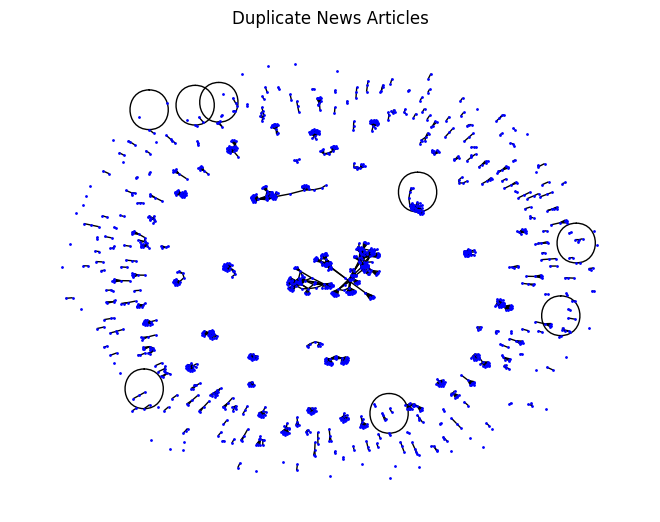

In [140]:
# Visualize the graph
pos = nx.spring_layout(G, seed=42)  # Positioning algorithm
nx.draw(G, pos, with_labels=False, node_size=1, node_color='blue', font_size=10)
plt.title("Duplicate News Articles")
plt.show()

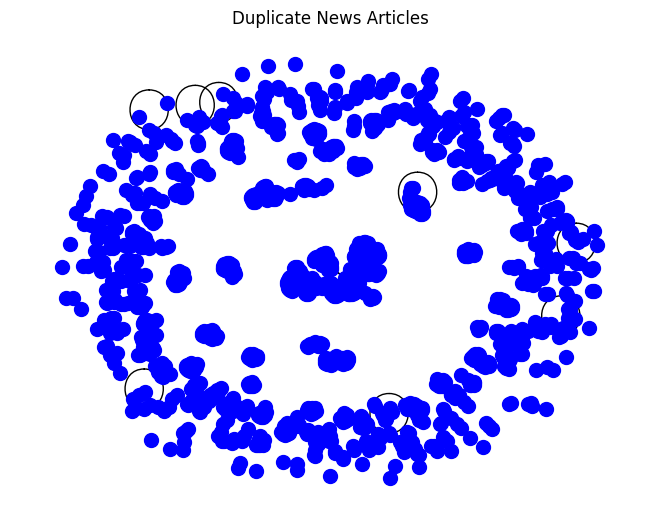

In [141]:
# Visualize the graph
pos = nx.spring_layout(G, seed=42)  # Positioning algorithm
nx.draw(G, pos, with_labels=False, node_size=100, node_color='blue', font_size=10)
plt.title("Duplicate News Articles")
plt.show()

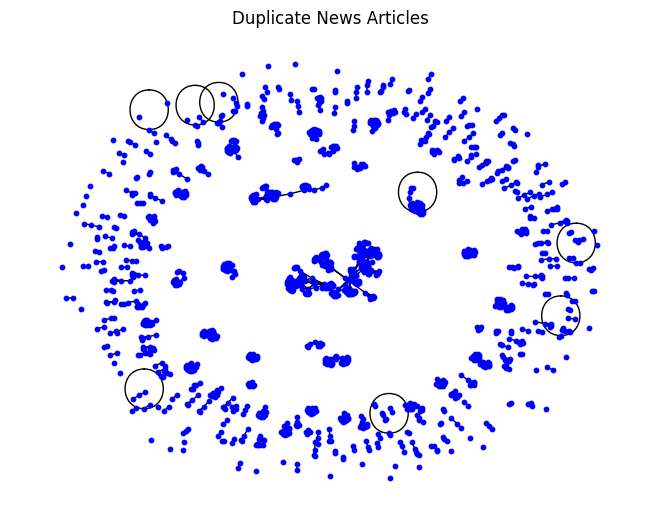

In [142]:
# Visualize the graph
pos = nx.spring_layout(G, seed=42)  # Positioning algorithm
nx.draw(G, pos, with_labels=False, node_size=10, node_color='blue', font_size=10)
plt.title("Duplicate News Articles")
plt.show()

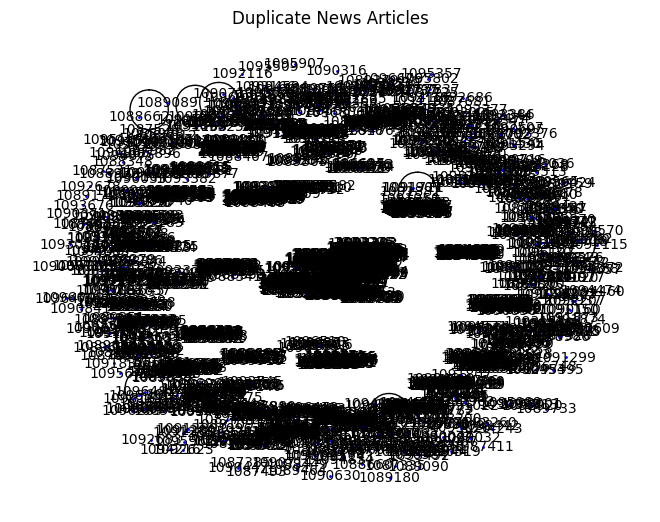

In [143]:
# Visualize the graph
pos = nx.spring_layout(G, seed=42)  # Positioning algorithm
nx.draw(G, pos, with_labels=True, node_size=1, node_color='blue', font_size=10)
plt.title("Duplicate News Articles")
plt.show()

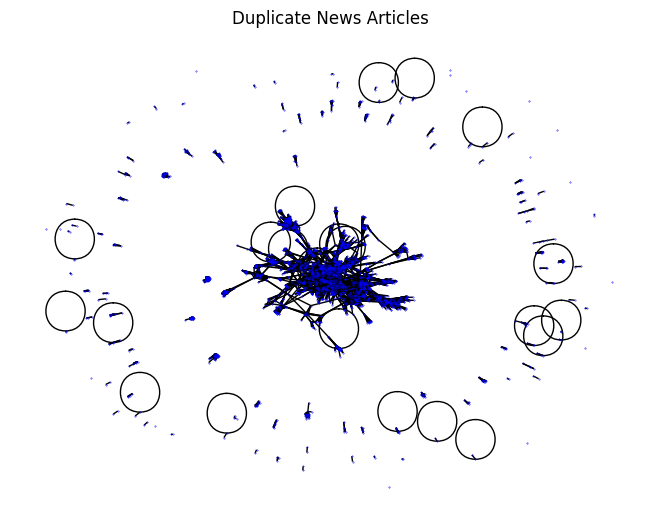

In [120]:
# Visualize the graph
pos = nx.spring_layout(G, seed=42)  # Positioning algorithm
nx.draw(G, pos, with_labels=False, node_size=0.1, node_color='blue', font_size=10)
plt.title("Duplicate News Articles")
plt.show()

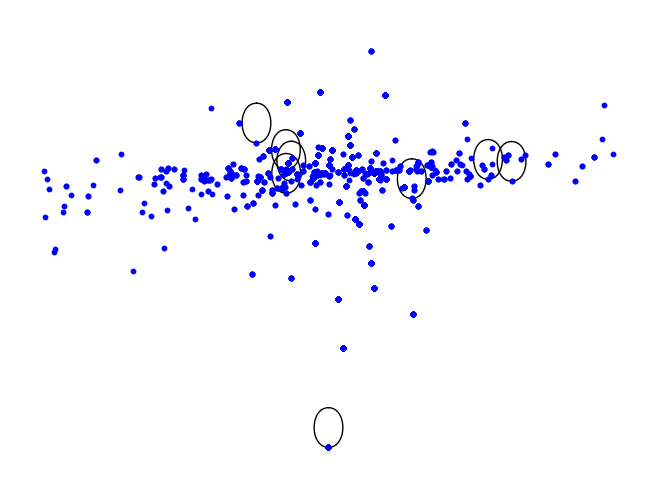

In [144]:
import networkx as nx
import matplotlib.pyplot as plt
import random


# Choose a layout algorithm
#pos = nx.spring_layout(G, seed=42)  # Spring layout positions nodes nicely

pos = nx.spectral_layout(G)

# Adjust visual parameters
node_size = 10
node_color = 'blue'
font_size = 10

# Draw the graph
nx.draw(G, pos, with_labels=False, node_size=node_size, node_color=node_color, font_size=font_size)

# Display the graph
plt.axis('off')  # Turn off the axis
plt.show()


In [ ]:
  

result = df.loc[df['NewsKey'] == 1000541]
print("===result===")
print(result)
if not result.empty:
    headline = result['Headline'].values[0]
    description = result['Description'].values[0][:100]  # First 50 characters of Description
    print("--------")
    print("Headline of duplicate news:", headline)
    print("Description of duplicate news:", description)
    print("--------")

In [82]:
really = df.loc[df['NewsKey'] == 1071684]

In [83]:
really

,NewsKey,Headline,Description,p_IsAccident,Summary,AccidentTypes,ExtractedDate,DuplicateOfNewsID,combined_text
13267,1071684,29p ‘effective’ cleaning agent that can clear ...,Whether you are PERSON or not there is one sig...,0.046772,Whether you are PERSON or not there is one sig...,{},2023-09-29,-1,29p ‘effective’ cleaning agent that can clear ...
